In [6]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import json
from anytree.importer import JsonImporter
from anytree import PreOrderIter

In [7]:
from scipy import stats
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel,ttest_ind

In [8]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
optimx = importr('optimx')
pbkrtest = importr('pbkrtest')
lmerTest = importr('lmerTest')
ggplot = importr('ggplot2')
dplyr = importr('dplyr')
sjplot = importr('sjPlot')
car = importr('car')
# fitdistrplus = importr('fitdistrplus')
boot = importr('boot')

In [9]:
home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
out_dir = home_dir + 'figures/figures_all/'
R_out_dir = home_dir + 'R_analysis_data/'

In [10]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

with open(home_dir +'tree_data/undo_tree', 'r') as file:
    undo_tree = json.load(file)

In [11]:
# helper functions
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if p == 0:
        axs.text((x1+x2)*.5, y+h,  r"$p = {:.1f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"$p = {0:s}$".format(as_si(p,1)), ha='center', va='bottom', color=col, fontsize = 8)
    elif p > 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.2f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

    elif 0.01 < p < 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.3f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.4f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

# histogram of number of cities within reach

<IPython.core.display.Javascript object>


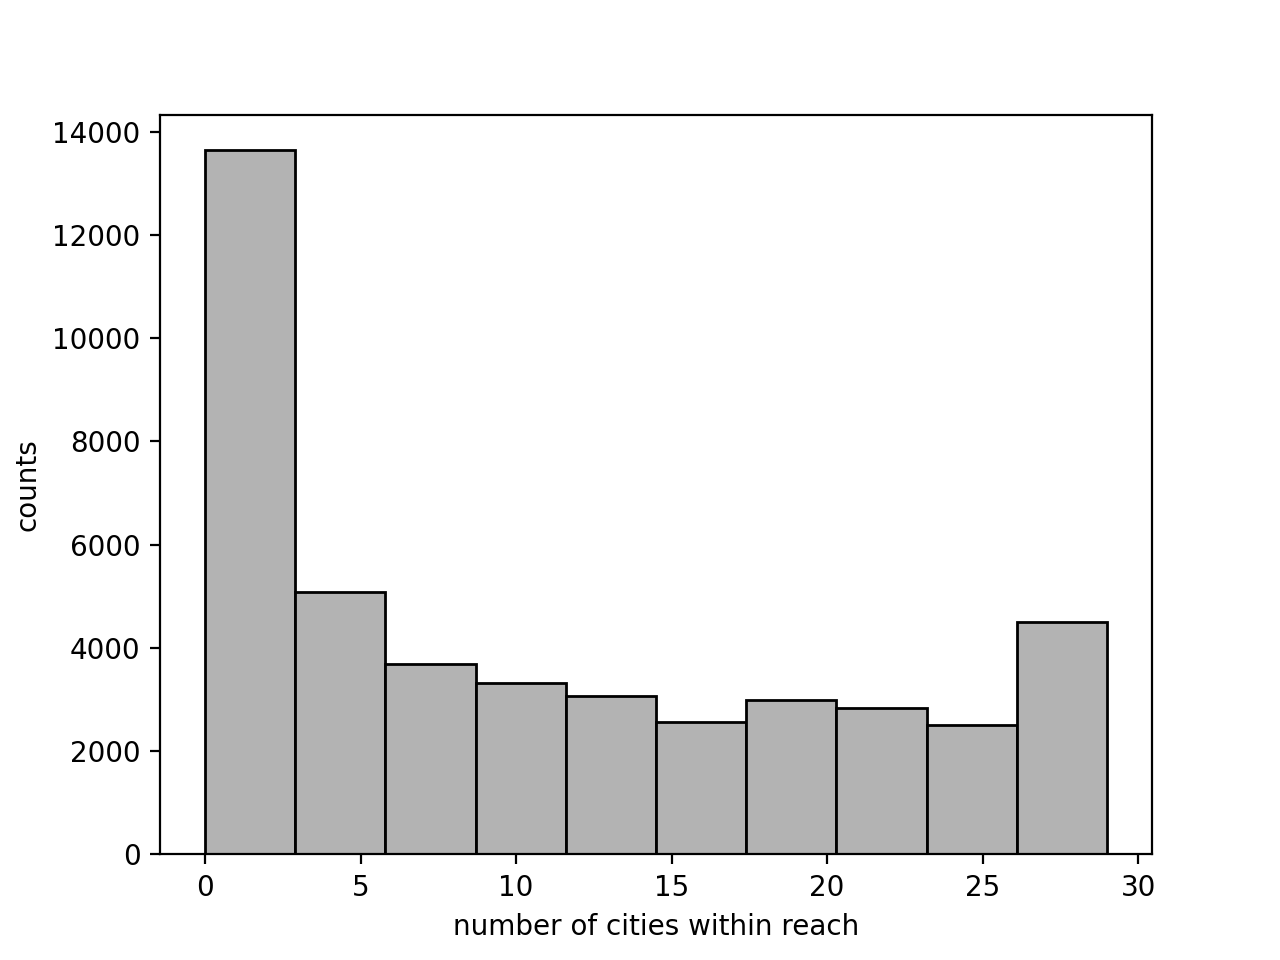

In [7]:
n_reach = data_choice_level[data_choice_level['condition']==0]['within_reach'] # only basic condition

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(n_reach,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('number of cities within reach') 
plt.show()

# Undo initial state

## 1. budget before submit/undo at the end of trial

In [8]:
# only undo condition
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[df_beforeUndo['checkEnd'] == 1]
leftover_undo = df_beforeUndo.loc[index_end_undo,'leftover']

index_notundo = data_choice_level.index[(data_choice_level['undo'] == 0)&(data_choice_level['RT'] != -1)]
df_notbeforeUndo = data_choice_level.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo['checkEnd'] == 1)&(df_notbeforeUndo['condition'] == 1)]
leftover_notundo = df_notbeforeUndo.loc[index_end_notundo,'leftover']

<IPython.core.display.Javascript object>


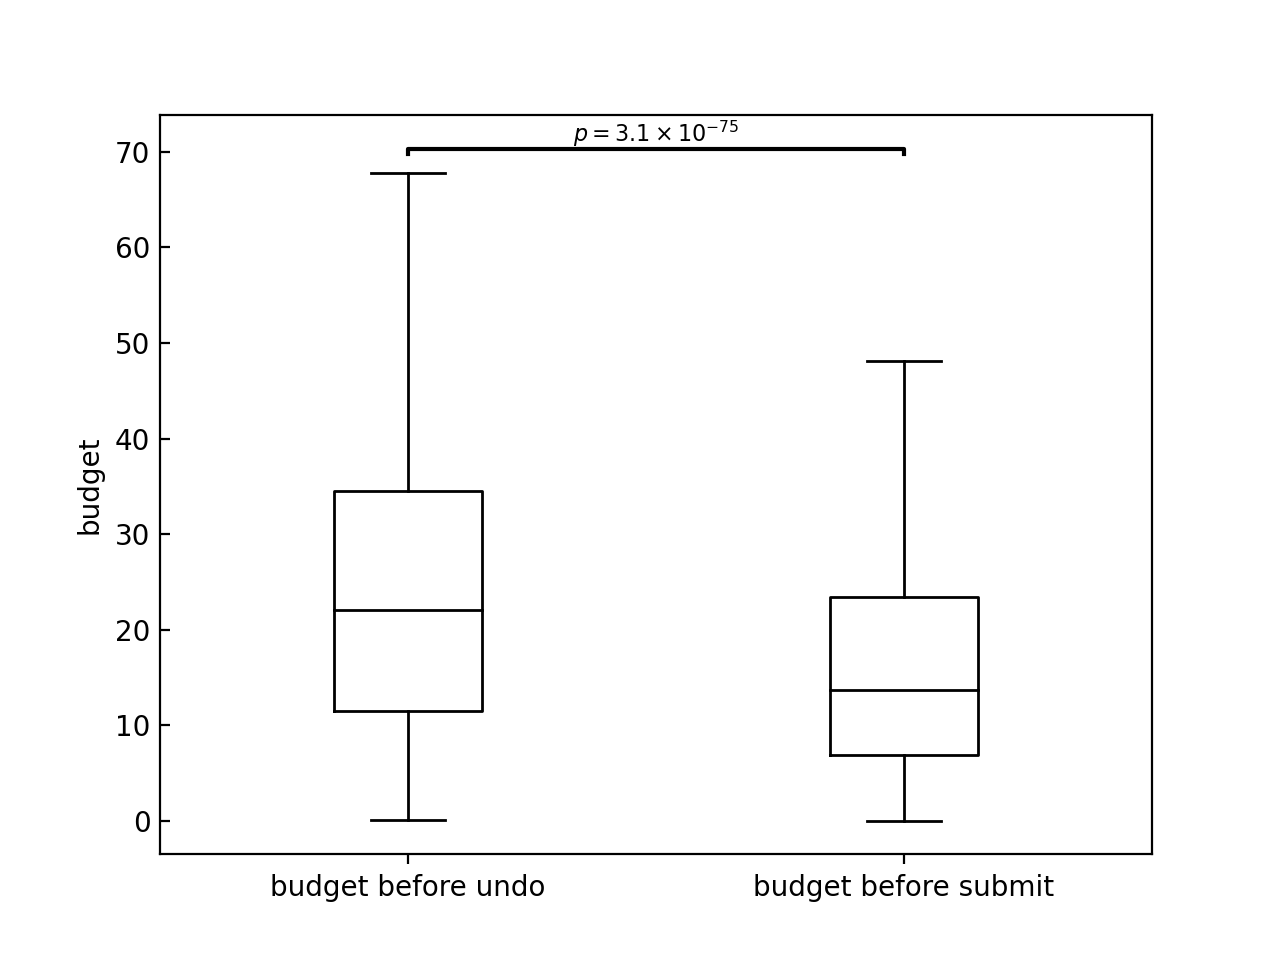

In [9]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot([leftover_undo,leftover_notundo],
   positions =[1,2],widths = 0.3,showfliers=False,whis = 1.5,
   medianprops = dict(color = 'k'))  #

# run 2-independent-sample t test
stat1, p1 = ttest_ind(leftover_undo,leftover_notundo,equal_var=False)
x1, x2 = 1,2  
if bx['caps'][1]._y[0] > bx['caps'][3]._y[0]:
    y, h, col = bx['caps'][1]._y[0] + 2, 0.5, 'k'
else:
    y, h, col = bx['caps'][3]._y[0] + 2, 0.5, 'k'

axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

#--------------------------------------
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['budget before undo','budget before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('budget') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

## 2.1 counts of errors before undo (by accumulated severity)

In [10]:
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]

MAS_trial = df_beforeUndo['allMAS']
accu_severity_error = MAS_trial - df_beforeUndo['currMas']
groupby_error = accu_severity_error.value_counts()
print(groupby_error/sum(groupby_error))

1    0.466917
0    0.231579
2    0.213534
3    0.063534
4    0.022556
5    0.001504
6    0.000376
dtype: float64


<IPython.core.display.Javascript object>


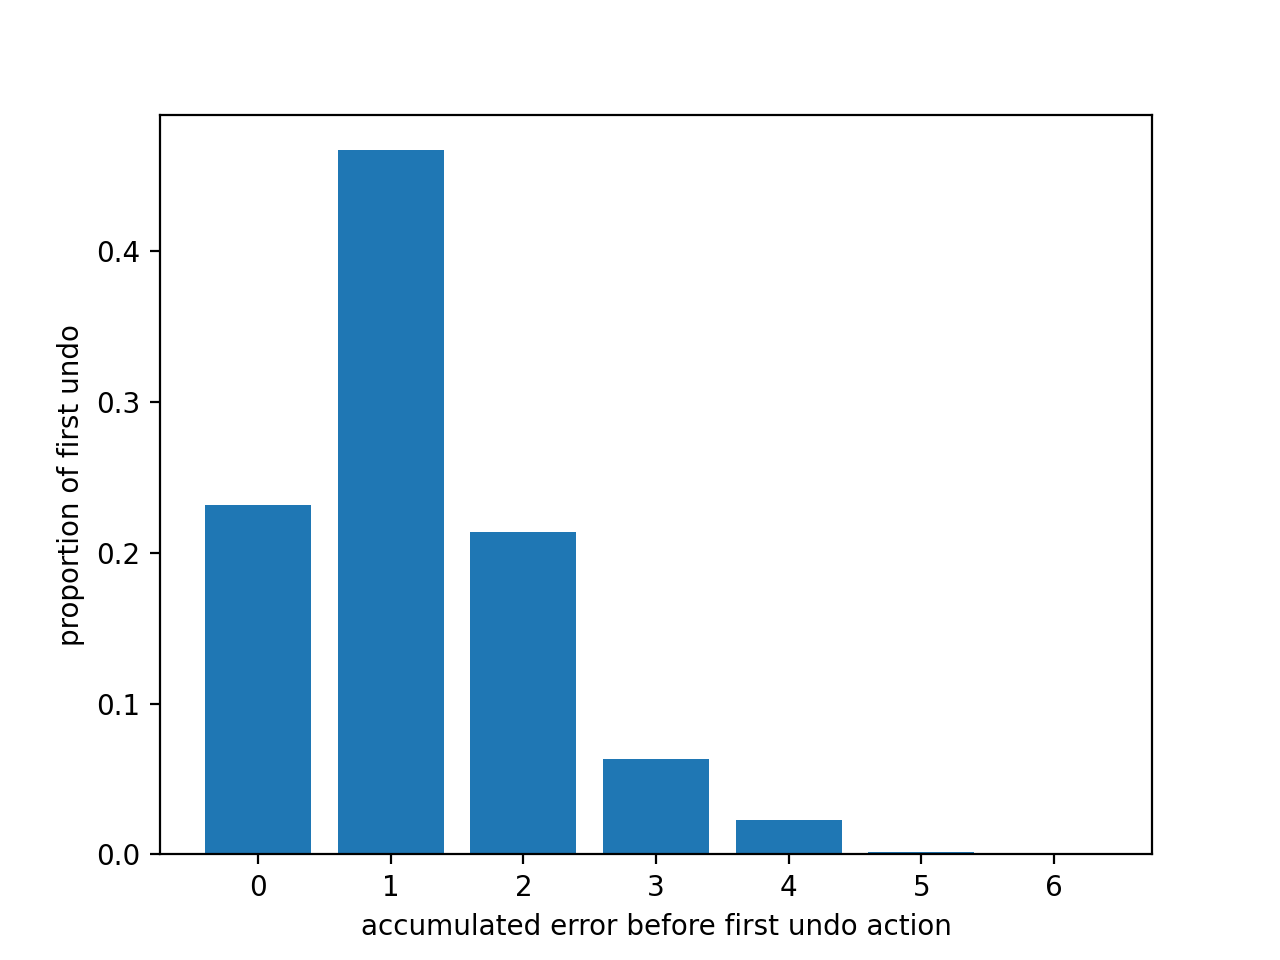

In [11]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar(groupby_error.index,groupby_error/sum(groupby_error))
axs.set_ylabel('proportion of first undo')
axs.set_xlabel('accumulated error before first undo action')
plt.show()
fig.savefig(out_dir + 'undo_accumulated_error.pdf', dpi=600, bbox_inches='tight')

In [12]:
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]

instant_severity_error = df_beforeUndo['severityOfErrors']
groupby_error_instant = instant_severity_error.value_counts()
print(groupby_error_instant)

0    2329
1     269
2      43
3      16
4       2
6       1
Name: severityOfErrors, dtype: int64


<IPython.core.display.Javascript object>


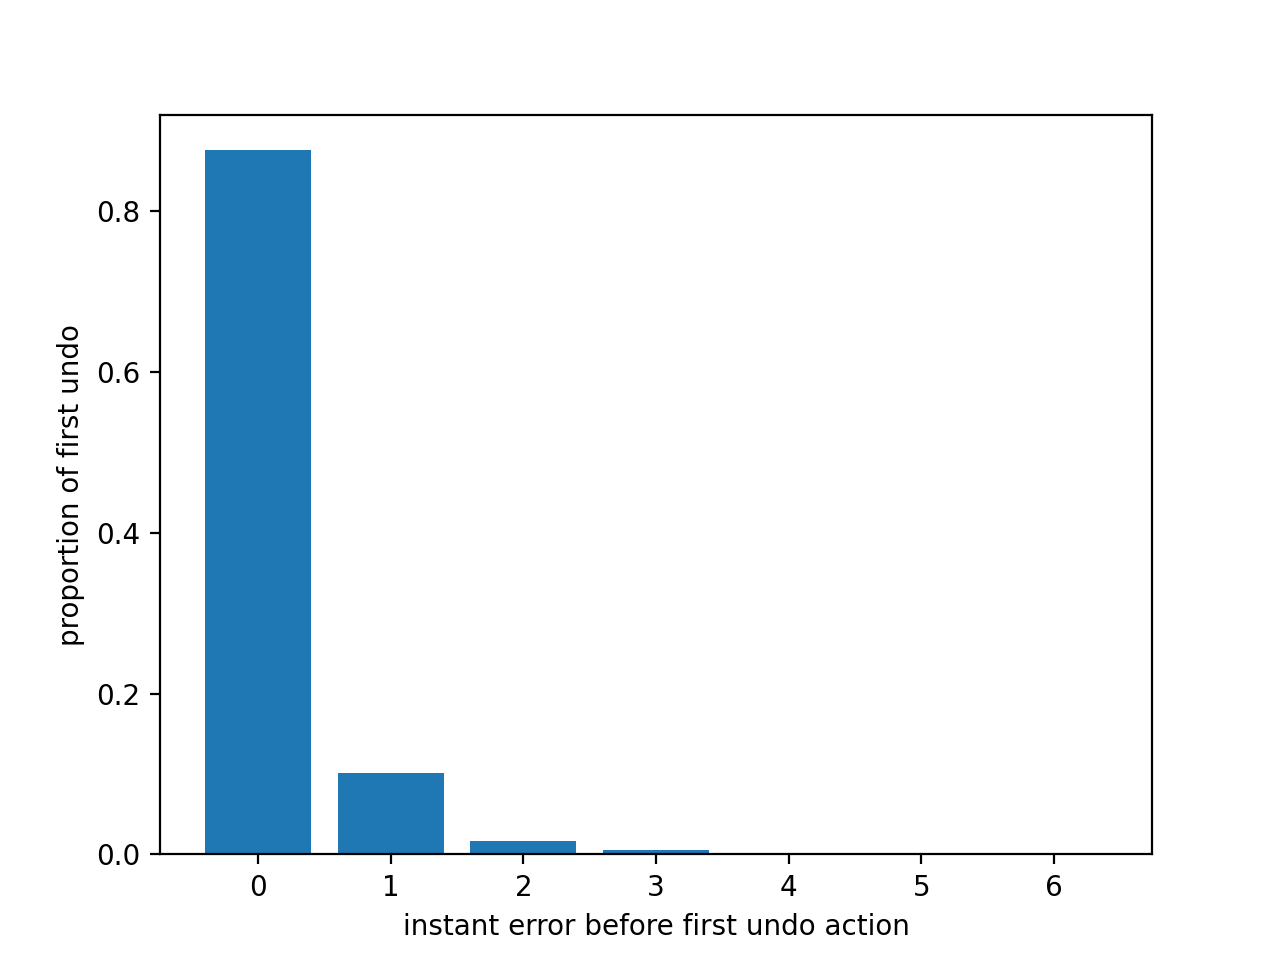

In [14]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar(groupby_error_instant.index,groupby_error_instant/sum(groupby_error_instant))
axs.set_ylabel('proportion of first undo')
axs.set_xlabel('instant error before first undo action')
plt.show()
# fig.savefig(out_dir + 'undo_instant_error.pdf', dpi=600, bbox_inches='tight')

In [15]:
# groupby_error_single = single_severity_error.value_counts()
# groupby_error_series = series_severity_error.value_counts()

# groupby_error_series.at[4] = 0
# groupby_error_series.at[6] = 0

In [16]:
index_single_undo =  data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] == 1)]
df_beforeSingleUndo = data_choice_level.loc[index_single_undo-1,:]

single_severity_error = df_beforeSingleUndo['severityOfErrors']
df_beforeSingleUndo['accumulatedError'] = df_beforeSingleUndo['allMAS'] - df_beforeSingleUndo['currMas']
groupby_error_single = df_beforeSingleUndo.groupby(['severityOfErrors','accumulatedError'])['subjects'].count()
groupby_error_single = groupby_error_single.reset_index()

groupby_error_single.loc[groupby_error_single['accumulatedError']>groupby_error_single['severityOfErrors'],'accumulatedError']= 'noninstant'
groupby_error_single = groupby_error_single.groupby(['severityOfErrors','accumulatedError']).sum()
groupby_error_single = groupby_error_single.reset_index()

groupby_error_single['undoType'] = 'single'



index_series_undo =  data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] != 1)]
df_beforeSeriesUndo = data_choice_level.loc[index_series_undo-1,:]

series_severity_error = df_beforeSeriesUndo['severityOfErrors']
df_beforeSeriesUndo['accumulatedError'] = df_beforeSeriesUndo['allMAS'] - df_beforeSeriesUndo['currMas']
groupby_error_series = df_beforeSeriesUndo.groupby(['severityOfErrors','accumulatedError'])['subjects'].count()
groupby_error_series = groupby_error_series.reset_index()

groupby_error_series.loc[groupby_error_series['accumulatedError']>groupby_error_series['severityOfErrors'],'accumulatedError']= 'noninstant'
groupby_error_series = groupby_error_series.groupby(['severityOfErrors','accumulatedError']).sum()
groupby_error_series = groupby_error_series.reset_index()

groupby_error_series['undoType'] = 'serial'

groupby_error = pd.concat([groupby_error_single,groupby_error_series])

# add empty entries
d = {'severityOfErrors': [4,4,4,6,6,6], 'accumulatedError': [4,'noninstant','noninstant', 6,'noninstant','noninstant'],'subjects': [0,0,0,0,0,0],'undoType': ['serial','serial','single', 'serial','serial','single',]}
df = pd.DataFrame(data=d)
groupby_error = pd.concat([groupby_error,df]).reset_index()
print(groupby_error)

    index  severityOfErrors accumulatedError  subjects undoType
0       0                 0                0       169   single
1       1                 0       noninstant       205   single
2       2                 1                1       111   single
3       3                 1       noninstant        36   single
4       4                 2                2        23   single
5       5                 2       noninstant         9   single
6       6                 3                3         8   single
7       7                 3       noninstant         2   single
8       8                 4                4         2   single
9       9                 6                6         1   single
10      0                 0                0       447   serial
11      1                 0       noninstant      1508   serial
12      2                 1                1        57   serial
13      3                 1       noninstant        65   serial
14      4                 2             

## 2.1.1 different errors lead to different types of undo?

<IPython.core.display.Javascript object>


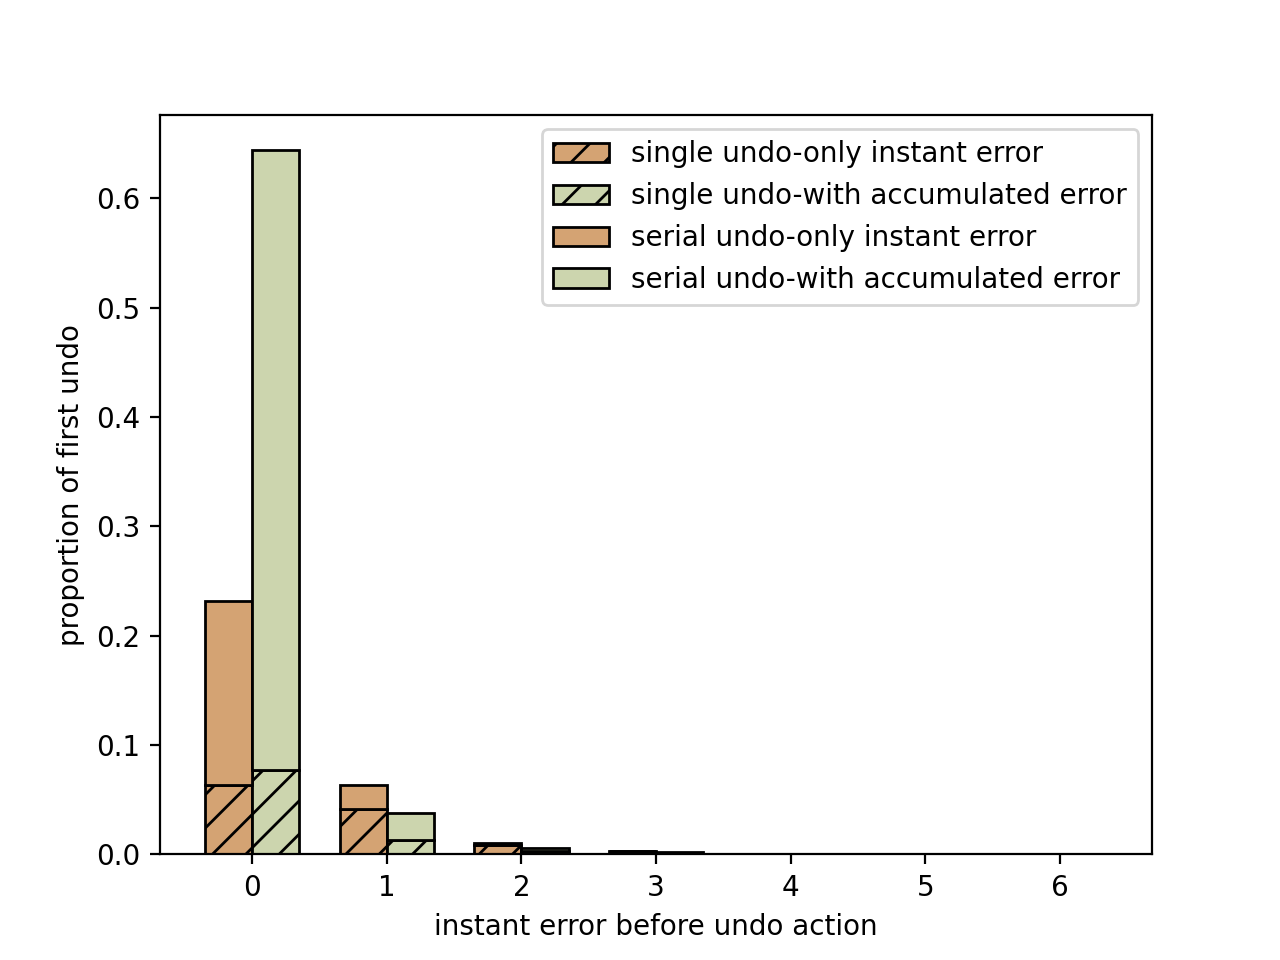

In [17]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
single_index1 = (groupby_error['accumulatedError']!='noninstant')&(groupby_error['undoType']=='single')
single_index2 = (groupby_error['accumulatedError']=='noninstant')&(groupby_error['undoType']=='single')
single_proportion = groupby_error.loc[single_index1 ,'subjects']/sum(groupby_error['subjects'])
single_proportion2 = groupby_error.loc[single_index2 ,'subjects']/sum(groupby_error['subjects'])

serial_index1 = (groupby_error['accumulatedError']!='noninstant')&(groupby_error['undoType']=='serial')
serial_index2 = (groupby_error['accumulatedError']=='noninstant')&(groupby_error['undoType']=='serial')

x = groupby_error.loc[single_index1 ,'severityOfErrors']
width = 0.35  # the width of the bars

axs.bar(x - width/2, single_proportion, width, label='single undo-only instant error',hatch='//',color='#d4a373',edgecolor='black')
axs.bar(x + width/2, single_proportion2, width, label='single undo-with accumulated error',hatch='//',color='#ccd5ae',edgecolor='black')
axs.bar(x - width/2, groupby_error.loc[serial_index1 ,'subjects']/sum(groupby_error['subjects']),width, bottom=single_proportion,
       label='serial undo-only instant error',color='#d4a373',edgecolor='black')
axs.bar(x + width/2, groupby_error.loc[serial_index2 ,'subjects']/sum(groupby_error['subjects']),width, bottom=single_proportion2,
       label='serial undo-with accumulated error',color='#ccd5ae',edgecolor='black')

axs.set_ylabel('proportion of first undo')
axs.set_xlabel('instant error before undo action')
axs.legend()
plt.show()
fig.savefig(out_dir + 'undotype_errortype.pdf', dpi=600, bbox_inches='tight')

## 2.2 probability of undo -- conditional on error

In [18]:
# FROM EACH SUBJECT
dat_subjects = []
for i in np.unique(np.array(data_choice_level['subjects'])):
    temp_data = []
    index_subjects =  data_choice_level.index[data_choice_level['subjects'] == i]
    
    puzzle_error = data_choice_level['allMAS'] - data_choice_level['currMas']
    
    # no error
    index_error = puzzle_error.index[puzzle_error == 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))


    # YES error
    index_error = puzzle_error.index[puzzle_error != 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))
    
    dat_subjects.append(temp_data)

dat_subjects = np.array(dat_subjects)
print(np.mean(dat_subjects,axis=0))
print(np.unique(np.array(data_choice_level['subjects'])))

[0.00736323 0.03944057]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


<IPython.core.display.Javascript object>


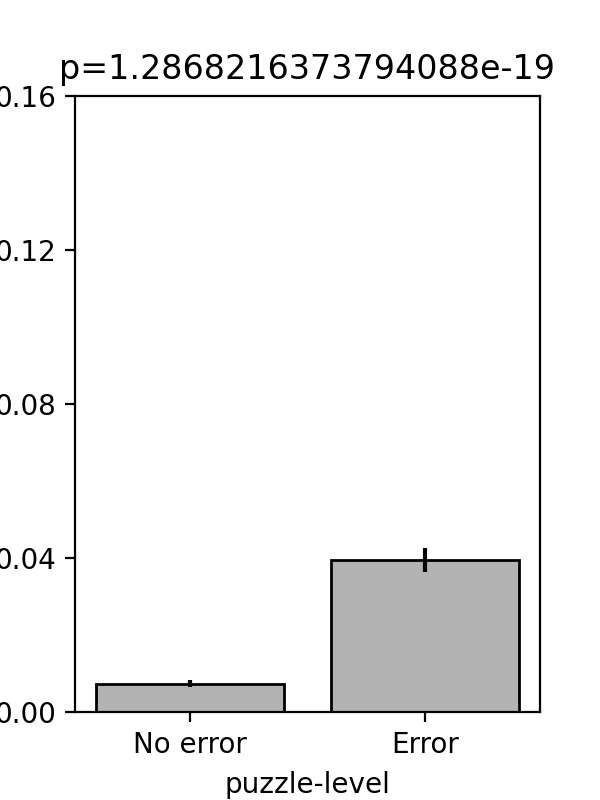

-10.102424395604347
1.2868216373794088e-19


Text(0.5, 1.0, 'p=1.2868216373794088e-19')

In [19]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar([1,2],np.mean(dat_subjects,axis = 0),color=[.7,.7,.7], edgecolor = 'k', yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))
axs.set_ylabel('P (undo)')
axs.set_xticks([1,2])
axs.set_yticks(np.linspace(0,0.16,5))
axs.set_xticklabels(labels = ['No error', 'Error'])#,fontsize=18
fig.set_figheight(4)
fig.set_figwidth(3)
axs.set_xlabel('puzzle-level')
plt.show()
# fig.savefig(out_dir + 'conditional_undo_masError.pdf', dpi=600, bbox_inches='tight')

from scipy.stats import ttest_ind
stat1, p1 = ttest_ind(dat_subjects[:,0], dat_subjects[:,1])
print(stat1)
print(p1)
axs.set_title('p=' + str(p1))

In [20]:
# FROM EACH SUBJECT
dat_subjects = []
for i in np.unique(np.array(data_choice_level['subjects'])):
    temp_data = []
    index_subjects =  data_choice_level.index[data_choice_level['subjects'] == i]
    
    # no error
    index_error = data_choice_level['severityOfErrors'].index[data_choice_level['severityOfErrors'] == 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))


    # YES error
    index_error = data_choice_level['severityOfErrors'].index[data_choice_level['severityOfErrors'] != 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))
    
    dat_subjects.append(temp_data)

dat_subjects = np.array(dat_subjects)

<IPython.core.display.Javascript object>


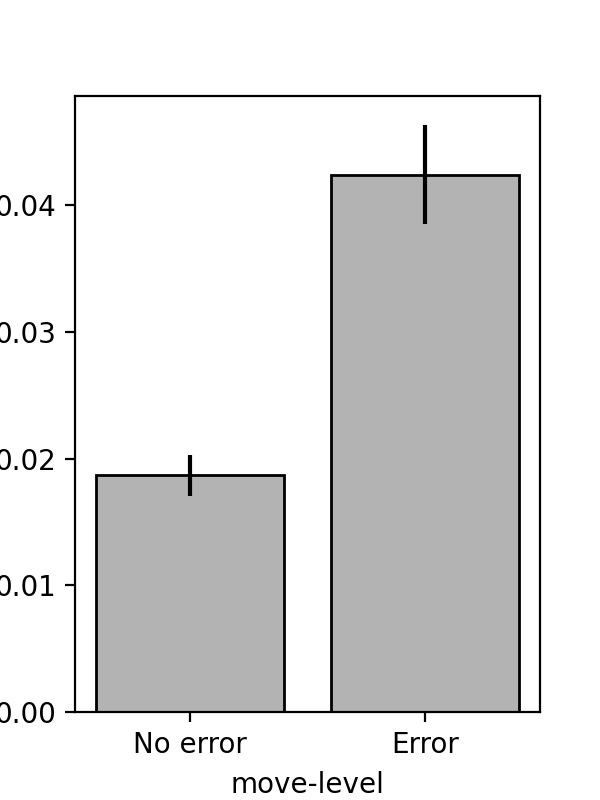

In [21]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar([1,2],np.mean(dat_subjects,axis = 0),color=[.7,.7,.7], edgecolor = 'k', yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))
axs.set_ylabel('P (undo)')
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['No error', 'Error'])#,fontsize=18
fig.set_figheight(4)
fig.set_figwidth(3)
axs.set_xlabel('move-level')
plt.show()
# fig.savefig(out_dir + 'conditional_pundo_givenError.pdf', dpi=600, bbox_inches='tight')


-5.585070622500876
7.642034989210063e-08


<IPython.core.display.Javascript object>


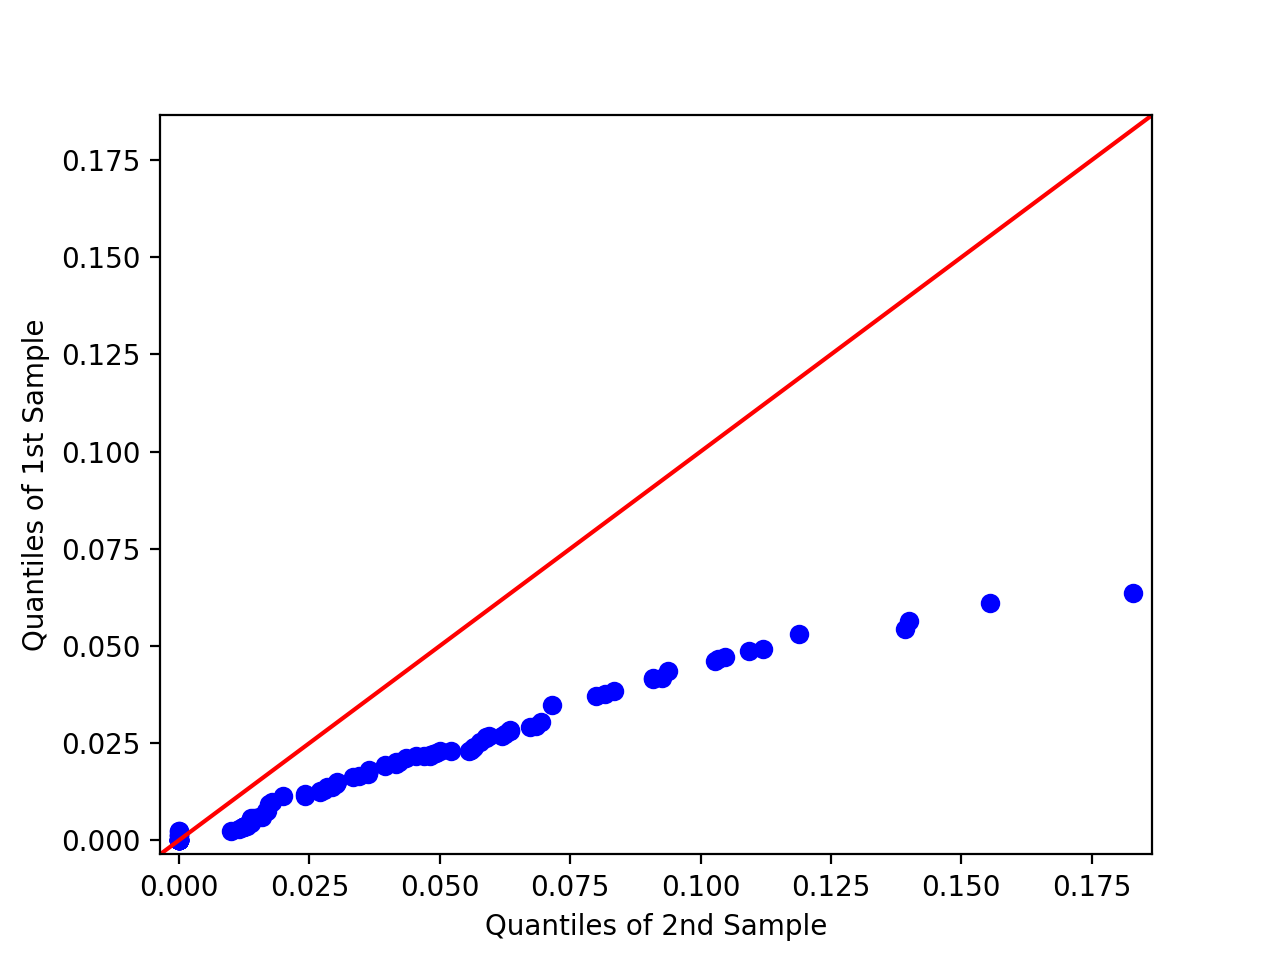

In [22]:
ttest_ind
stat1, p1 = ttest_ind(dat_subjects[:,0], dat_subjects[:,1])
print(stat1)
print(p1)
import statsmodels.api as sm
import pylab as py
# sm.qqplot(stats.zscore(dat_subjects[:,0]), line ='45')
sm.qqplot_2samples(dat_subjects[:,0],dat_subjects[:,1],line ='45')
py.show()

# benefit of undo

## 1.1 number of undo - subjects

In [23]:
undo_puzzle = single_condition_data[single_condition_data['numUNDO']>0].groupby(['subjects']).size()
count = [len(single_condition_data.groupby(['subjects']).size())]
for i in range(1,47):
    count.append(sum(undo_puzzle>=i))

<IPython.core.display.Javascript object>


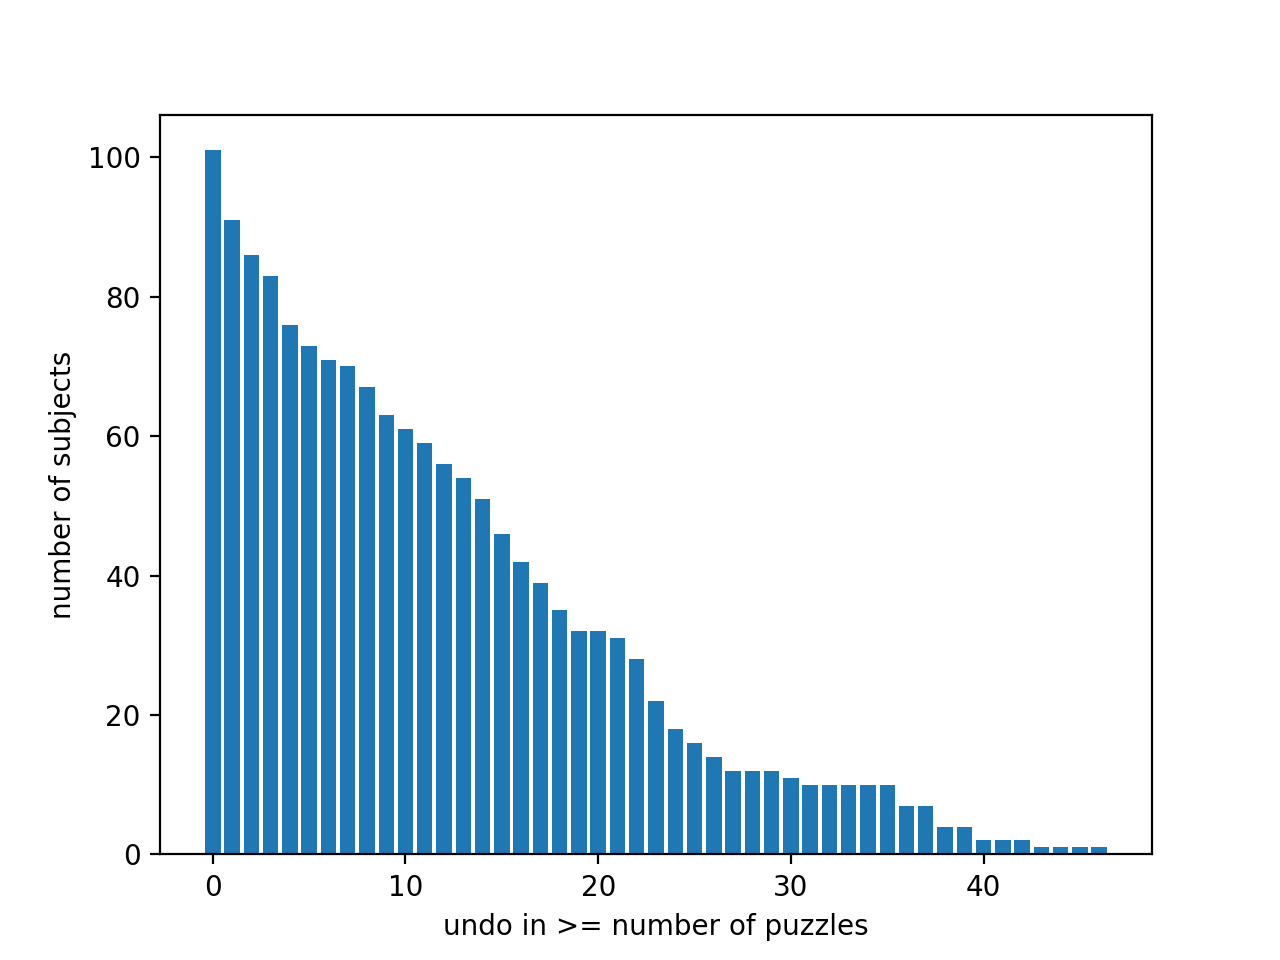

Text(0, 0.5, 'number of subjects')

In [24]:
fig, axs = plt.subplots()

plt.bar(list(range(0,47)),count)
axs.set_xlabel("undo in >= number of puzzles")
axs.set_ylabel("number of subjects")
# axs.plot(bins[1][:-1], bins[0], color = '#81b29a', linewidth=3)

## 1.2 number of undo - puzzles

<IPython.core.display.Javascript object>


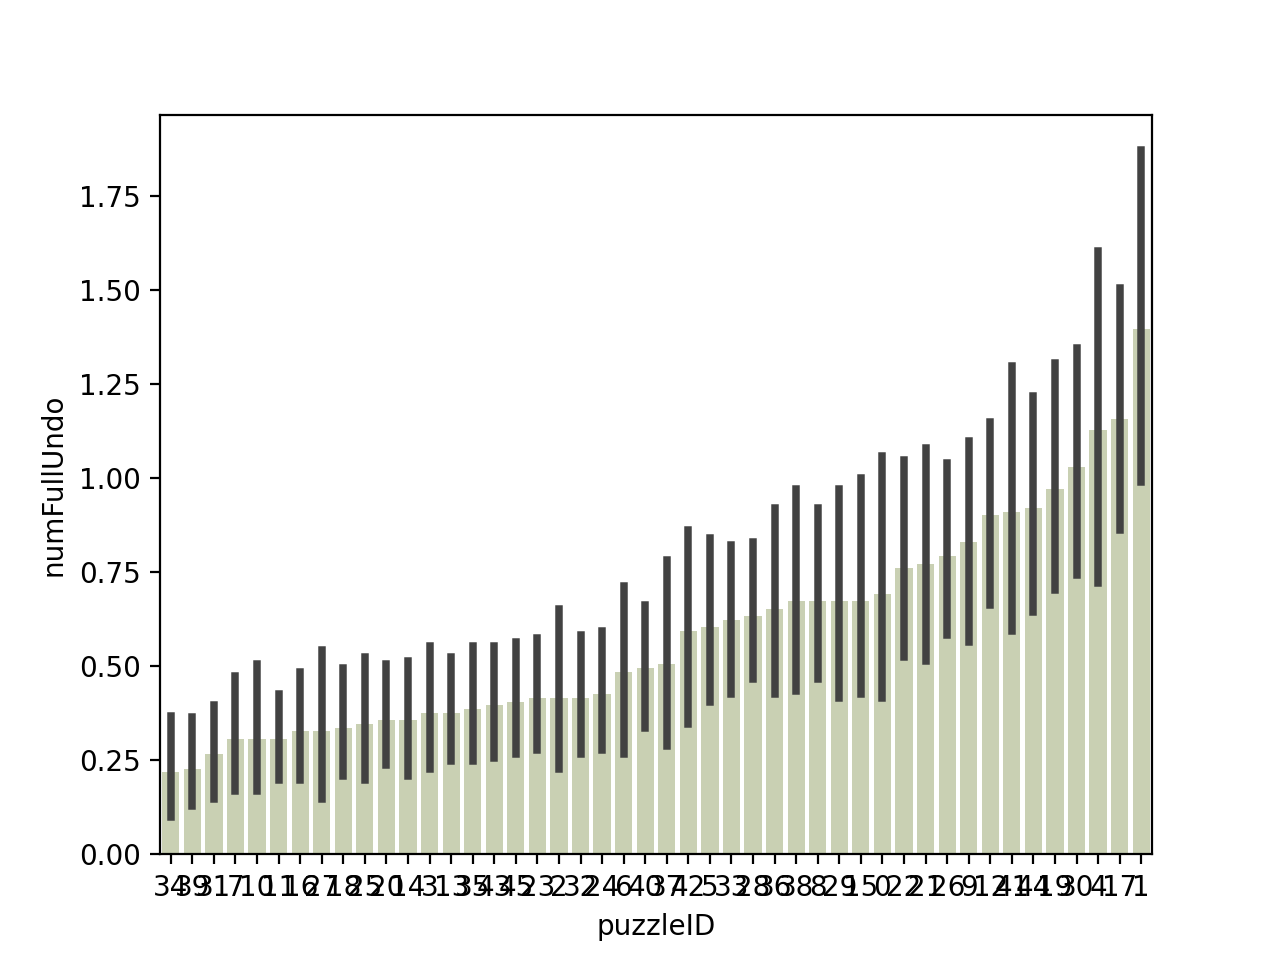

In [25]:
order = single_condition_data.groupby(['puzzleID'])['numFullUndo'].mean().to_frame()
sort_order = order.sort_values('numFullUndo')

%matplotlib notebook
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='puzzleID', y='numFullUndo', data = single_condition_data, color = '#ccd5ae',order=sort_order.index) 


## 1.3.1 benefits of undo - num of full undoing

In [26]:
basic_score = puzzleID_order_data[puzzleID_order_data['condition']==0]['numCities'].reset_index(drop=True)
basic_score_z = basic_score/puzzleID_order_data[puzzleID_order_data['condition']==0]['mas'].reset_index(drop=True)
single_condition_data['numCities_z'] = single_condition_data['numCities']/single_condition_data['mas']

single_condition_data['undo_benefit'] = single_condition_data['numCities'] - basic_score
single_condition_data['undo_benefit_z'] = single_condition_data['numCities_z'] - basic_score_z

undo_benefit_z_sub = single_condition_data.groupby(['subjects'])['undo_benefit_z'].mean()
undo_count_sub = single_condition_data.groupby(['subjects'])['numFullUndo'].mean()

In [28]:
benefit_undo = (np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['numCities']) 
        - np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['numCities']))

undo_count = np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['numFullUndo'])

yerr = stats.binned_statistic(undo_count, benefit_undo, statistic=lambda y: np.std(y)/np.sqrt(len(y)), bins=[0,1,2,3,4,100])
bins = stats.binned_statistic(undo_count, benefit_undo, 'mean', bins=[0,1,2,3,4,100])

<IPython.core.display.Javascript object>


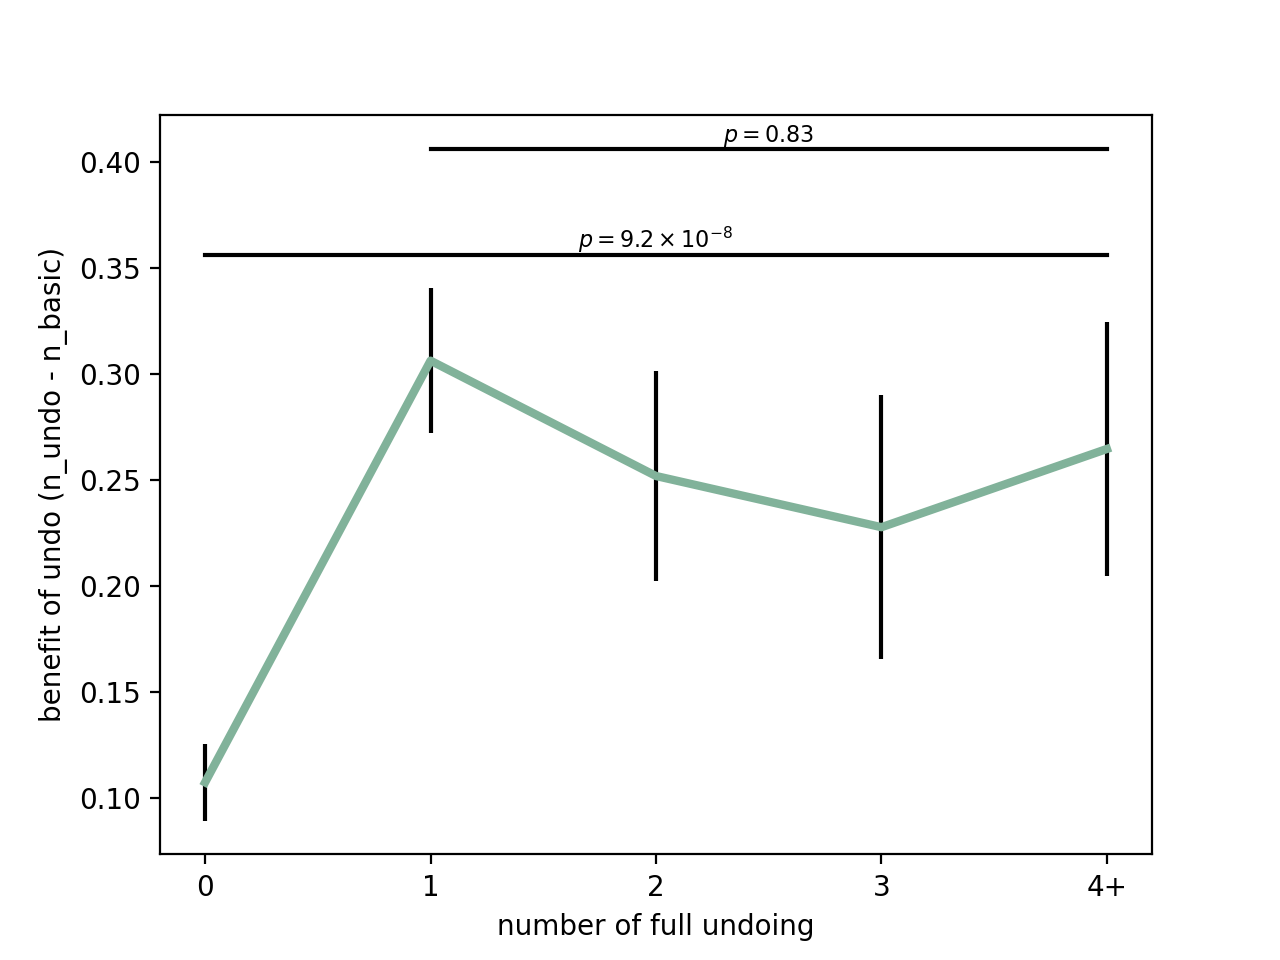

In [29]:
fig, axs = plt.subplots()         
axs.plot(bins[1][:-1], bins[0], color = '#81b29a', linewidth=3)
plotline1, caplines1, barlinecols1 = axs.errorbar(bins[1][:-1], bins[0], yerr[0], capsize = 0, ls='None', color='k')

# non-parametric version of anova (because number of observations is different: https://www.reneshbedre.com/blog/anova.html)
# Kruskal-Wallis Test
stat1, p1 = stats.kruskal(benefit_undo[undo_count==1], benefit_undo[undo_count==2], benefit_undo[undo_count==3],benefit_undo[undo_count>=4])
x1, x2 = 1,4  
y, h, col = bins[0][1] + 0.1, 0, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

stat2, p2 = stats.kruskal(benefit_undo[undo_count==0], benefit_undo[undo_count==1], benefit_undo[undo_count==2], benefit_undo[undo_count==3],benefit_undo[undo_count>=4])
x1, x2 = 0,4  
y, h, col = bins[0][1] + 0.05, 0, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p2)

axs.set_xticks([0,1,2,3,4])
axs.set_xticklabels([0,1,2,3,'4+'])
axs.set_xlabel('number of full undoing')
axs.set_ylabel('benefit of undo (n_undo - n_basic)')
fig.savefig(out_dir + 'undobenefit_undonum.png', dpi=600, bbox_inches='tight')

## 1.3.2 benefits of undo - num of full undoing (scatter plot)

In [30]:
scatter_data = single_condition_data.groupby(['undo_benefit_z','numFullUndo'])['index'].size().to_frame(name = 'count').reset_index()

<IPython.core.display.Javascript object>


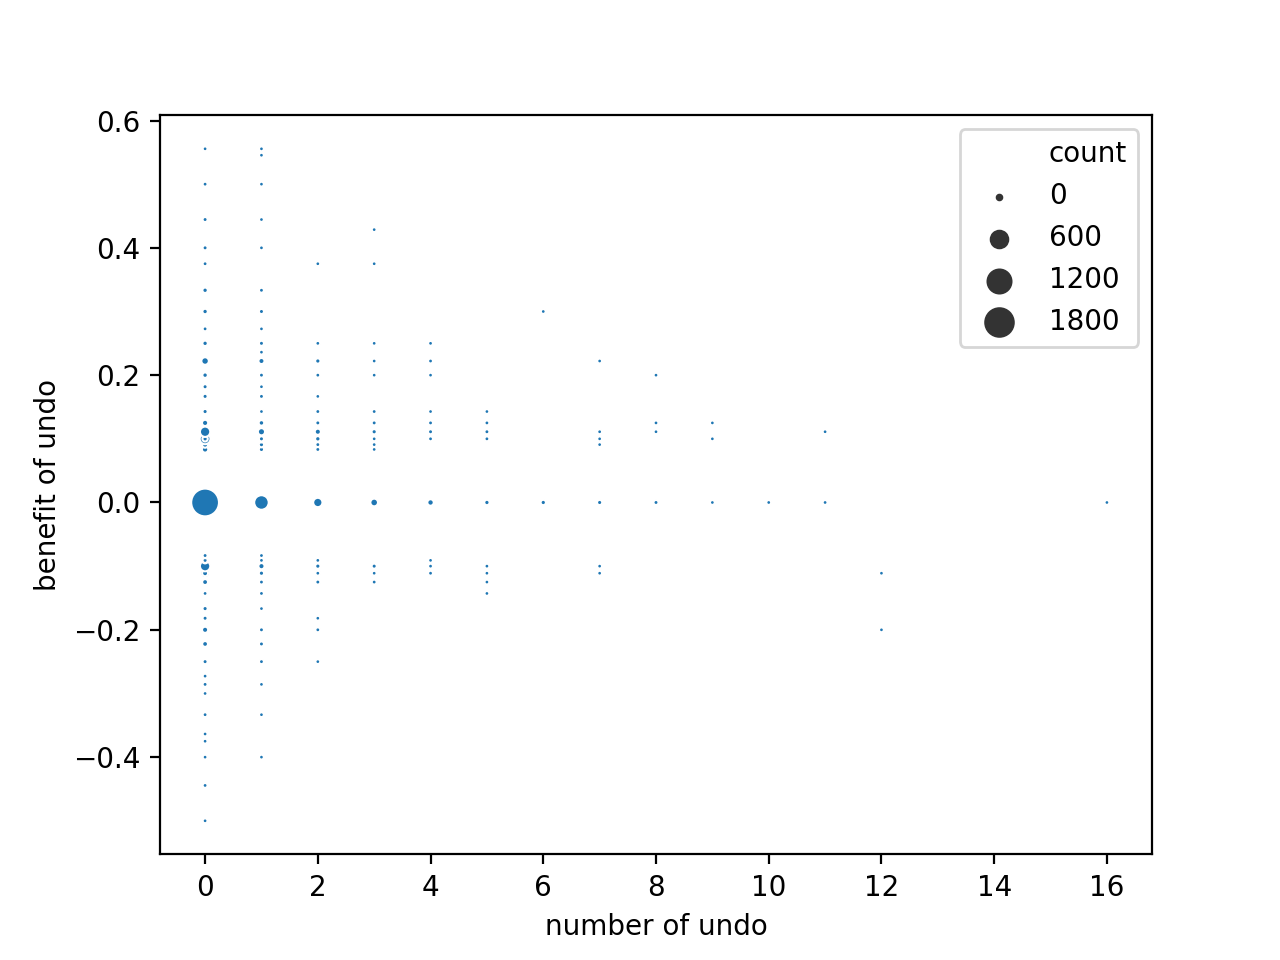

Text(0, 0.5, 'benefit of undo')

In [31]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='numFullUndo', y='undo_benefit_z', size = scatter_data['count'], sizes = (3,100), data=scatter_data) 
ax1.set_xlabel("number of undo")
ax1.set_ylabel("benefit of undo")

## 1.3.3 benefits of undo - num of full undoing (subject-level correlation)

<IPython.core.display.Javascript object>


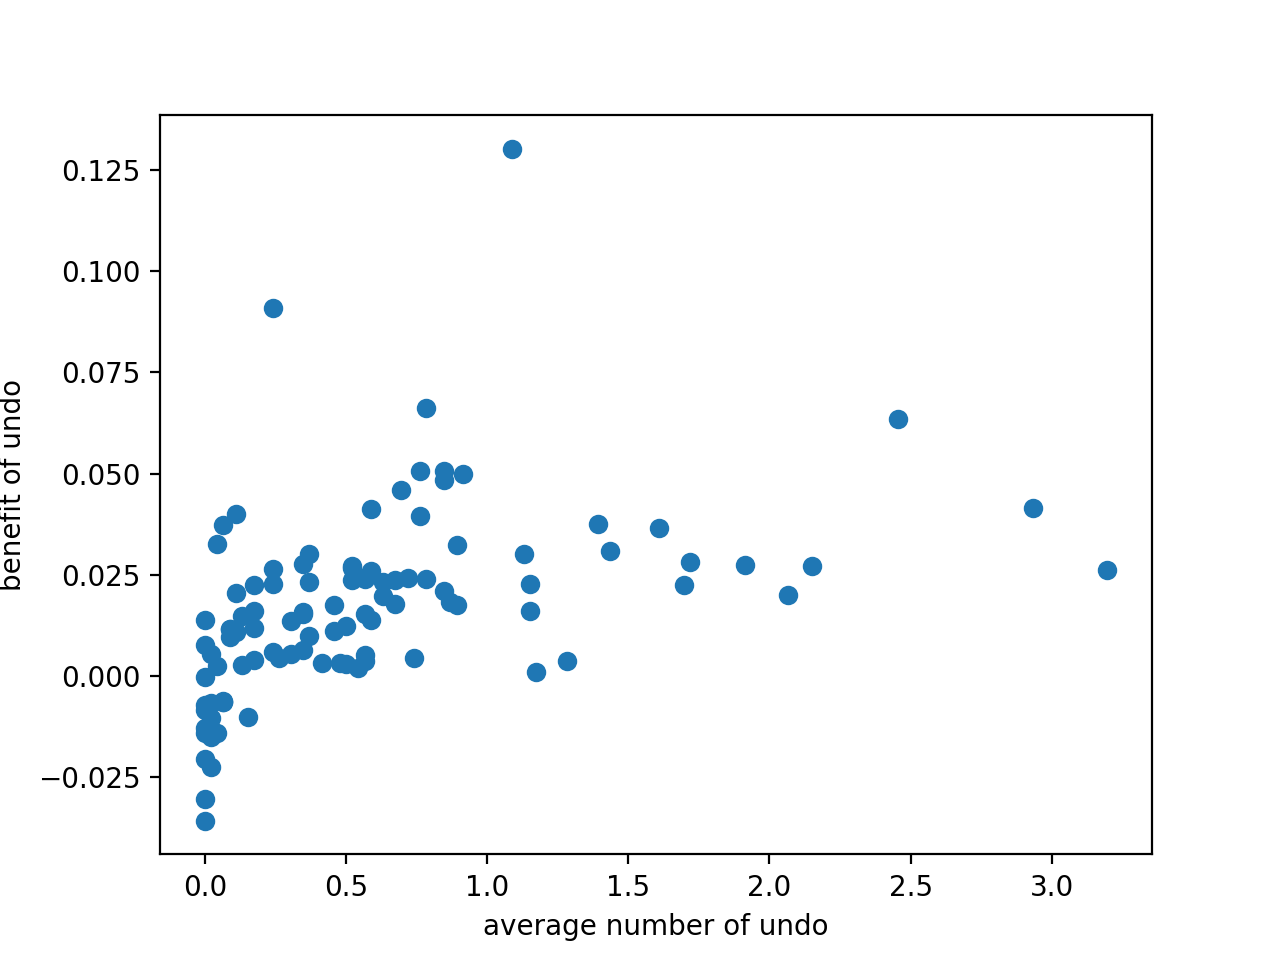

In [32]:
fig11, ax1 = plt.subplots()
ax1.plot(undo_count_sub,undo_benefit_z_sub,'o')
ax1.set_xlabel("average number of undo")
ax1.set_ylabel("benefit of undo")
fig11.savefig(out_dir + 'undobenefit_individual.pdf', dpi=600, bbox_inches='tight')

In [33]:
#TODO: with a caption stating that each point is a subject, the Spearman rho, and the p-value
stats.spearmanr(undo_count_sub,undo_benefit_z_sub)

SpearmanrResult(correlation=0.6452190299000218, pvalue=3.262810817975453e-13)

## 1.3.4 benefits of undo - num of full undoing (puzzle-level correlation)

<IPython.core.display.Javascript object>


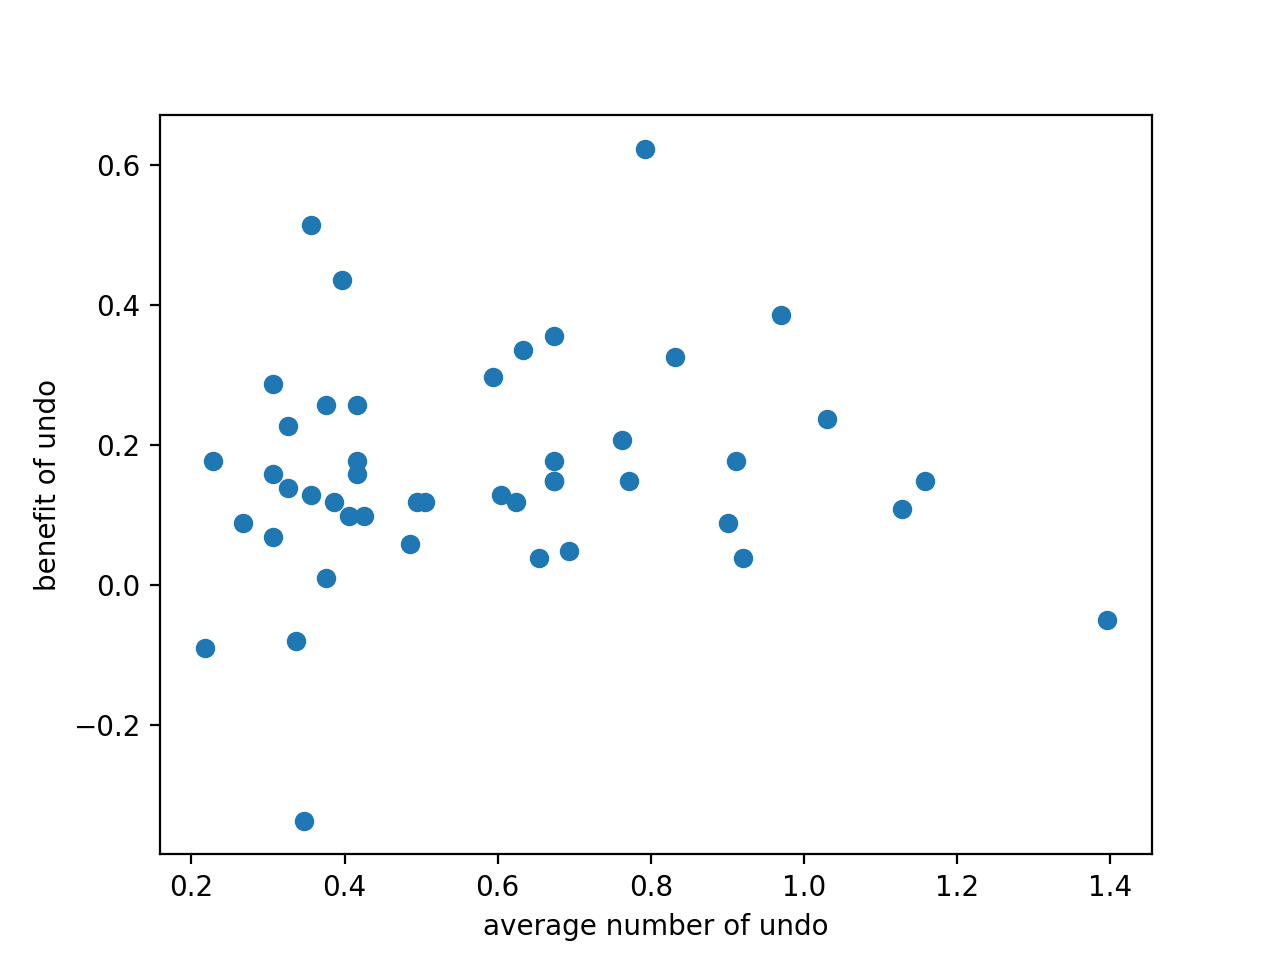

Text(0, 0.5, 'benefit of undo')

In [34]:
undo_benefit_puzzle = single_condition_data.groupby(['puzzleID'])['undo_benefit'].mean()
undo_count_puzzle = single_condition_data.groupby(['puzzleID'])['numFullUndo'].mean()
fig1, ax1 = plt.subplots()
ax1.plot(undo_count_puzzle,undo_benefit_puzzle,'o')
ax1.set_xlabel("average number of undo")
ax1.set_ylabel("benefit of undo")

## 1.4 GLMM benefit of undo - number of undo

In [ ]:
basic_score = puzzleID_order_data[puzzleID_order_data['condition']==0]['numCities'].reset_index(drop=True)
basic_score_z = basic_score/puzzleID_order_data[puzzleID_order_data['condition']==0]['mas'].reset_index(drop=True)
single_condition_data['numCities_z'] = single_condition_data['numCities']/single_condition_data['mas']

single_condition_data['undo_benefit'] = single_condition_data['numCities'] - basic_score
single_condition_data['undo_benefit_z'] = single_condition_data['numCities_z'] - basic_score_z

undo_benefit_z_sub = single_condition_data.groupby(['subjects'])['undo_benefit_z'].mean()
undo_count_sub = single_condition_data.groupby(['subjects'])['numFullUndo'].mean()

In [ ]:
%%R -i single_condition_data
#https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia
single_condition_data$subjects <- factor(single_condition_data$subjects)
single_condition_data$puzzleID <- factor(single_condition_data$puzzleID)
single_condition_data$mas <- factor(single_condition_data$mas)
# single_condition_data$numFullUndo[single_condition_data$numFullUndo >4] <- 4
# single_condition_data$numFullUndo <- factor(single_condition_data$numFullUndo)

str(single_condition_data)

In [ ]:
%%R

model = lmer(undo_benefit_z ~ numFullUndo + (numFullUndo|subjects),
                                  data=single_condition_data , control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model)

In [ ]:
%%R
# anova(model)
# plot(model)

ranef(model)
## QQ-plots:
# par(mfrow = c(1, 2))
# qqnorm(ranef(model)$subjects[, 1], main = "Random effects of subjects")
# qqnorm(resid(model), main = "Residuals")

qqPlot(resid(model), distribution = "norm")

## 1.5 GLMM：missed points - number of undo

In [7]:
puzzleID_order_data['missed_points'] = puzzleID_order_data['mas'] - puzzleID_order_data['numCities']
puzzleID_order_data = puzzleID_order_data[puzzleID_order_data['missed_points'] >= 0]

In [21]:
%%R -i puzzleID_order_data

puzzleID_order_data$subjects <- factor(puzzleID_order_data$subjects)
puzzleID_order_data$puzzleID <- factor(puzzleID_order_data$puzzleID)
puzzleID_order_data$condition <- factor(puzzleID_order_data$condition)
puzzleID_order_data$missed_points_sqrt <- sqrt(puzzleID_order_data$missed_points)
str(puzzleID_order_data)

'data.frame':	9291 obs. of  20 variables:
 $ subjects          : Factor w/ 101 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ puzzleID          : Factor w/ 46 levels "0","1","2","3",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ reward            : int  81 81 36 49 100 100 64 81 81 81 ...
 $ numCities         : int  9 9 6 7 10 10 8 9 9 9 ...
 $ mas               : int  9 9 7 7 10 10 10 10 10 10 ...
 $ nos               : int  104 104 6 6 70 70 34 34 4 4 ...
 $ leftover          : num  1.37 12.88 26.52 20.82 28.4 ...
 $ numError          : int  0 1 1 3 0 0 2 1 1 1 ...
 $ sumSeverityErrors : int  0 1 1 3 0 0 2 1 1 1 ...
 $ condition         : Factor w/ 2 levels "0","1": 1 2 1 2 1 2 1 2 1 2 ...
 $ numUNDO           : int  0 6 0 11 0 7 0 0 0 0 ...
 $ numFullUndo       : int  0 1 0 3 0 1 0 0 0 0 ...
 $ numEnd            : int  1 2 1 4 1 2 1 1 1 1 ...
 $ TT                : num  21.3 48.6 22.2 62.3 20 ...
 $ RT1               : num  6.78 6.99 8.73 12.95 4.69 ...
 $ RTlater           : num  2.44 3 4.1

In [23]:
%%R
 #
model0 = lme4::glmer(missed_points ~  numFullUndo + (1|subjects) + (1|puzzleID) ,#+ (condition + 0 | subjects)
                                  data = puzzleID_order_data, family = "poisson")

# get the coefficients for the best fitting model
summary(model0)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: missed_points ~ numFullUndo + (1 | subjects) + (1 | puzzleID)
   Data: puzzleID_order_data

     AIC      BIC   logLik deviance df.resid 
 19074.7  19103.2  -9533.3  19066.7     9287 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9007 -0.6574 -0.3378  0.4837  7.1753 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2591   0.5090  
 puzzleID (Intercept) 0.1968   0.4437  
Number of obs: 9291, groups:  subjects, 101; puzzleID, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.44134    0.08406  -5.250 1.52e-07 ***
numFullUndo -0.08118    0.01860  -4.366 1.27e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
numFullUndo -0.054


In [15]:
%%R
# plot(model0) # https://stat.ethz.ch/R-manual/R-devel/library/nlme/html/plot.lme.html
ranef(model0)
## QQ-plots:
# par(mfrow = c(1, 2))
# qqnorm(ranef(model0)$subjects[, 1], main = "Random effects of subjects")
# qqnorm(resid(model0), main = "Residuals")

# qqPlot(resid(model0), distribution = "norm")

# https://stats.stackexchange.com/questions/295340/what-to-do-with-glm-gamma-when-residuals-are-not-normally-distributed/302413#302413
# model0.diag <- glm.diag(model0)
# glm.diag.plots(model0, model0.diag)

$subjects
       condition0   condition1   (Intercept)
1   -1.633971e-01 -0.285507408  0.2235382931
2   -1.428510e-01 -0.229790925 -0.1420547212
3   -1.955902e-01 -0.333734594  0.1309140932
4   -1.119124e-01 -0.185943770 -0.0104499366
5   -7.899105e-02 -0.121115909 -0.1798783554
6    1.387891e-01  0.230879140  0.0082018173
7   -6.709874e-02 -0.108865889 -0.0508780073
8   -1.197215e-01 -0.184589557 -0.2552215044
9   -4.514553e-02 -0.060948948 -0.2436883378
10  -4.600111e-02 -0.084813818  0.1384668450
11   5.686008e-02  0.090551573  0.0721076604
12   1.366718e-01  0.209384087  0.3141752551
13   1.742748e-01  0.288434045  0.0354443478
14   7.590960e-03  0.014564007 -0.0325280577
15  -3.333854e-01 -0.521516210 -0.5830685555
16  -1.238218e-01 -0.180986447 -0.4329976118
17   7.796268e-02  0.117347138  0.2148686403
18   1.031945e-01  0.101027707  1.2091588904
19  -9.985783e-02 -0.158389792 -0.1374867874
20   4.603776e-02  0.065552380  0.1906177717
21   2.640510e-01  0.436524133  0.0621216348


In [24]:
%%R

model1 = lme4::glmer(missed_points ~ condition + numFullUndo + (1|subjects) + (1|puzzleID),
                                  data = puzzleID_order_data, family = "poisson")

# get the coefficients for the best fitting model
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: missed_points ~ condition + numFullUndo + (1 | subjects) + (1 |  
    puzzleID)
   Data: puzzleID_order_data

     AIC      BIC   logLik deviance df.resid 
 19019.9  19055.5  -9504.9  19009.9     9286 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0443 -0.6549 -0.3443  0.4758  7.5603 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2649   0.5146  
 puzzleID (Intercept) 0.1964   0.4432  
Number of obs: 9291, groups:  subjects, 101; puzzleID, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.36682    0.08486  -4.322 1.54e-05 ***
condition1  -0.18624    0.02467  -7.550 4.34e-14 ***
numFullUndo -0.02930    0.01892  -1.549    0.121    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) cndtn1
condition1  -0.111  

In [25]:
%%R

anova(model0,model1)

Data: puzzleID_order_data
Models:
model0: missed_points ~ numFullUndo + (1 | subjects) + (1 | puzzleID)
model1: missed_points ~ condition + numFullUndo + (1 | subjects) + (1 | puzzleID)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model0    4 19075 19103 -9533.3    19067                         
model1    5 19020 19056 -9504.9    19010 56.828  1  4.757e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# count of error 

## 1. number of optimal solutions

<IPython.core.display.Javascript object>


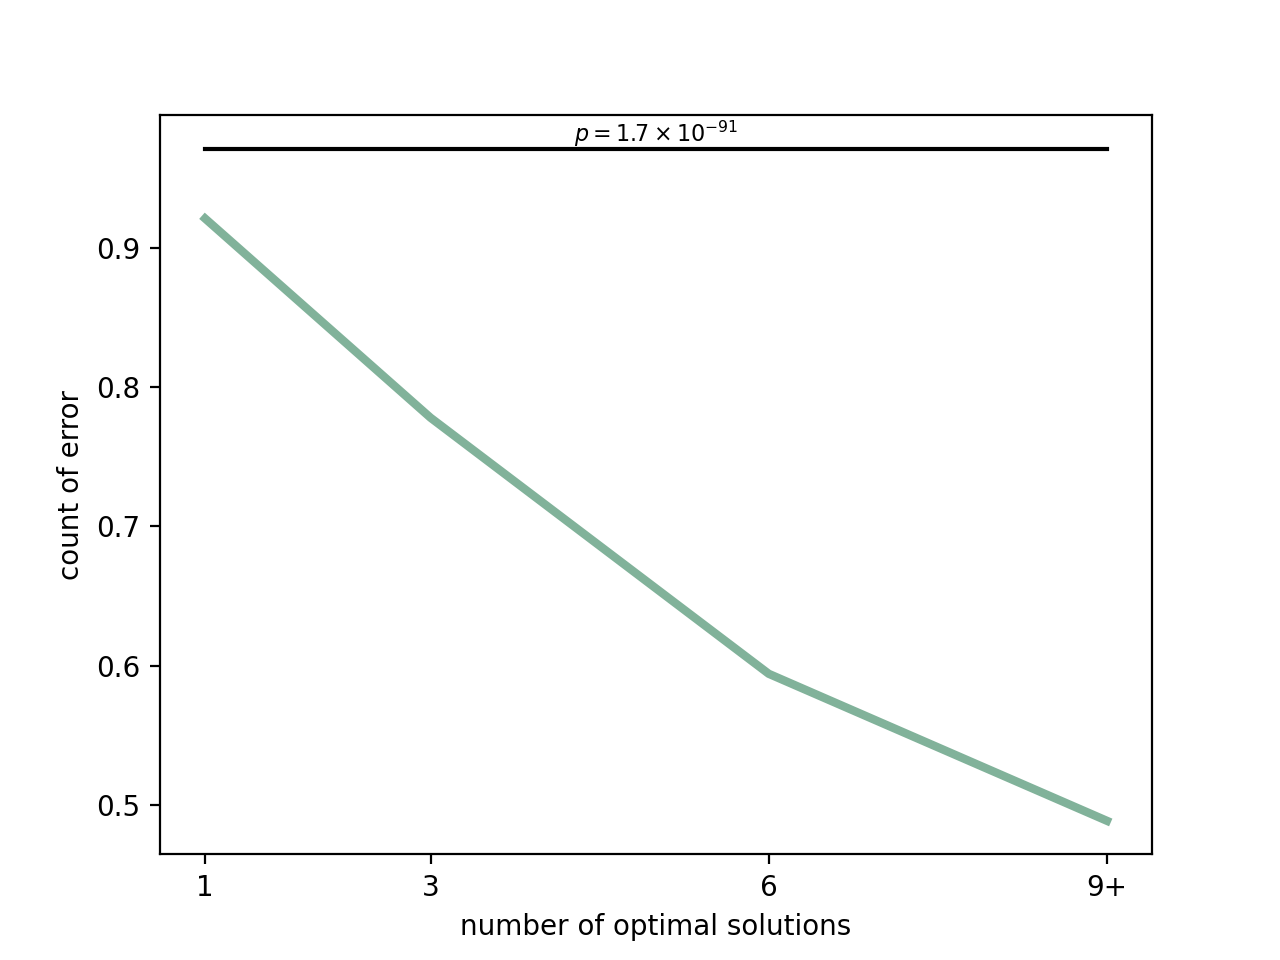

In [35]:
error_basic = np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['numError']) 
# error_undo = np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['numError']) 

n_optimal = np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['nos'])

bins1 = stats.binned_statistic(n_optimal, error_basic, 'mean', bins=[1,3,6,9,100])
# bins2 = stats.binned_statistic(n_optimal, error_undo, 'mean', bins=[1,3,6,9,15])

fig, axs = plt.subplots()         
axs.plot(bins1[1][:-1], bins1[0], color = '#81b29a', linewidth=3,label='basic')
# axs.plot(bins2[1][:-1], bins2[0],linewidth=3,label='undo')

# non-parametric version of anova (because number of observations is different: https://www.reneshbedre.com/blog/anova.html)
# Kruskal-Wallis Test
stat1, p1 = stats.kruskal(error_basic[(n_optimal<3) & (n_optimal>=1)], error_basic[(n_optimal<6) & (n_optimal>=3)], error_basic[(n_optimal<9) & (n_optimal>=6)],error_basic[n_optimal>=9])
x1, x2 = 1,9
y, h, col = bins1[0][0] + 0.05, 0, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

axs.set_xlabel('number of optimal solutions')
axs.set_ylabel('count of error')
axs.set_xticks([1,3,6,9])
axs.set_xticklabels([1,3,6,'9+'])
# axs.legend()
fig.savefig(out_dir + 'error_optimal.png', dpi=600, bbox_inches='tight')


# When people started undo and stopped

## 1.1 avarage across puzzle for each subject

In [45]:
# # Fixing random state for reproducibility
# np.random.seed(19680801)

# # # some random data
# # x = np.random.randn(1000)
# # y = np.random.randn(1000)

def scatter_hist(x, y, ax, ax_histx, ax_histy, alpha=1):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=alpha, color=[0,0,0])
    ax.set_xlabel('normalized number of cities connected (undo start)')
    ax.set_ylabel('normalized number of cities connected (undo target)')

    # now determine nice limits by hand:
    binwidth = 0.03
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color=[.7,.7,.7])
    ax_histy.hist(y, bins=bins, orientation='horizontal', color=[.7,.7,.7])

In [46]:
mas_map = [sc_data_choice_level.allMAS[sc_data_choice_level["puzzleID"]==i].tolist()[0] for i in np.unique(sc_data_choice_level['puzzleID'])]
str_ct = []
end_ct = []
str_ct_mean = []
end_ct_mean = []

for sub in range(100):
    str_ct_sbj = []
    end_ct_sbj = []
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        str_ct_pz = []
        end_ct_pz = []
        
        for index in range(len(dat_sbj_pzi)):# or mas_map[pzi
#             print(dat_sbj_pzi.currNumCities[index])
            # -1: so that it can be ranged from 0 to 1
            if dat_sbj_pzi.firstUndo[index] == 1:
#                 if dat_sbj_pzi.currNumCities[index]+1-1 <= 0:
#                     print(dat_sbj_pzi.currNumCities[index])
                str_ct_pz.append((dat_sbj_pzi.currNumCities[index]+1-1)/(mas_map[pzi]-1)) # or datum.currMas
                # because the dataset is counting startcity as 1

            if dat_sbj_pzi.lastUndo[index] == 1:
#                 if dat_sbj_pzi.currNumCities[index]-1 <= 0:
#                     print(dat_sbj_pzi.currNumCities[index])
                end_ct_pz.append((dat_sbj_pzi.currNumCities[index]-1)/(mas_map[pzi]-1))
      
        str_ct_sbj.extend(str_ct_pz)
        end_ct_sbj.extend(end_ct_pz)
        
    str_ct.extend(str_ct_sbj)
    end_ct.extend(end_ct_sbj)
    str_ct_mean.append(np.mean(str_ct_sbj))
    end_ct_mean.append(np.mean(end_ct_sbj))

In [47]:
end_ct_mean = np.array(end_ct_mean)
str_ct_mean = np.array(str_ct_mean)

str_ct_  = str_ct_mean[~np.isnan(str_ct_mean)]
end_ct_  = end_ct_mean[~np.isnan(end_ct_mean)]

# ind = np.argsort(str_ct_-end_ct_ )
ind = np.argsort(end_ct_ )

<IPython.core.display.Javascript object>


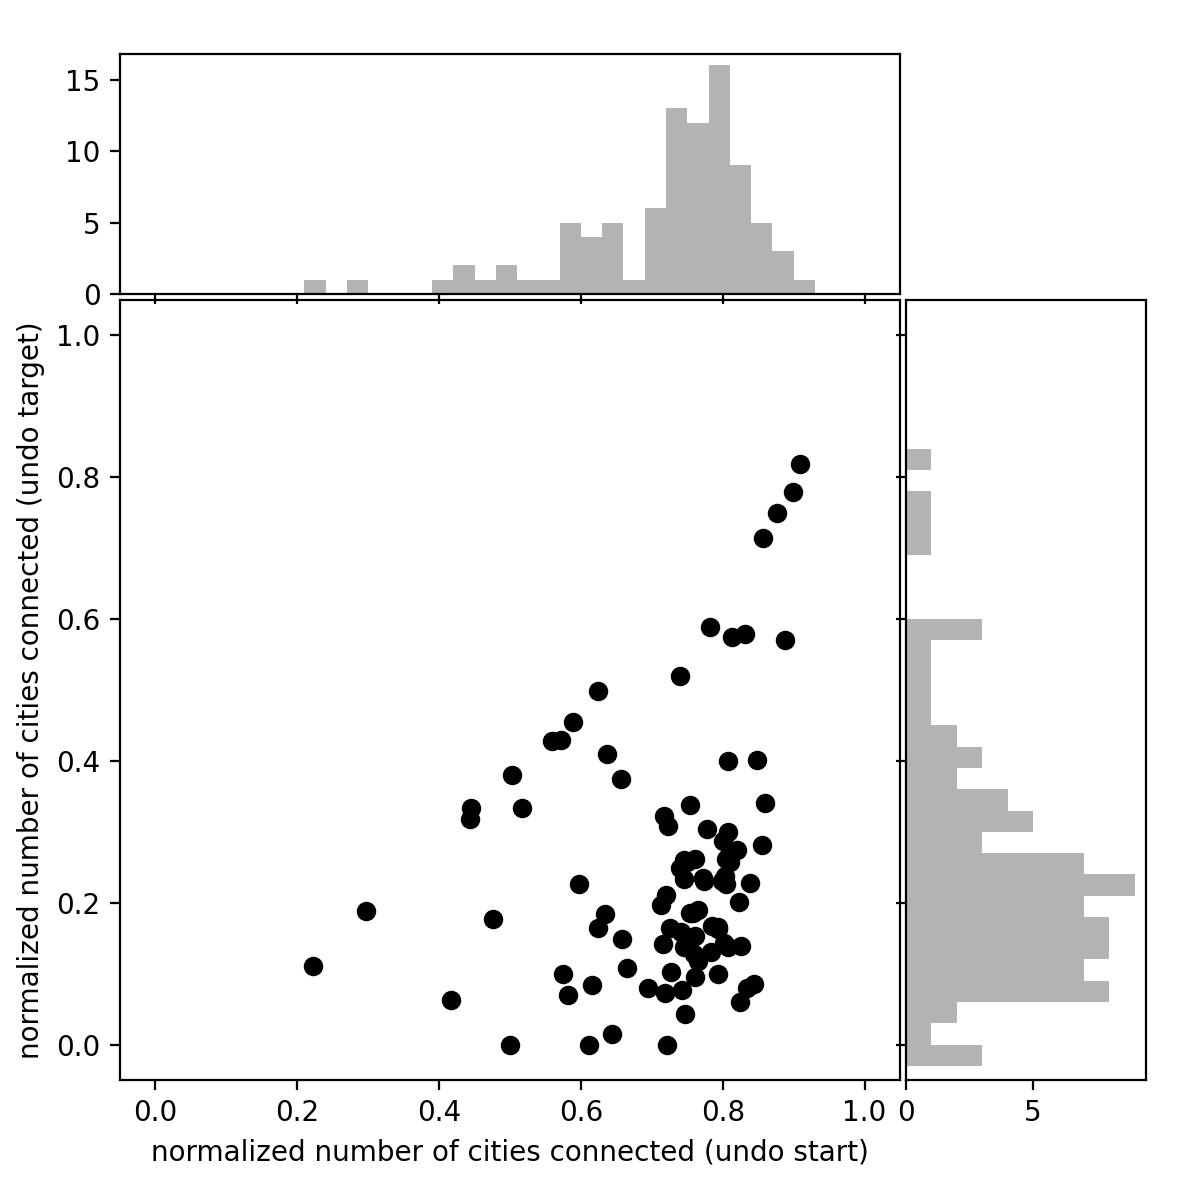

In [48]:
%matplotlib notebook
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(6, 6)) #

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
offset_ = .05# offset for better visualization
ax.set_xlim(0,1+offset_)
ax.set_ylim(0,1+offset_)
ax_histx.set_xlim(0-offset_,1+offset_)
ax_histy.set_ylim(0-offset_,1+offset_)
# use the previously defined function
scatter_hist(str_ct_, end_ct_, ax, ax_histx, ax_histy)

<IPython.core.display.Javascript object>


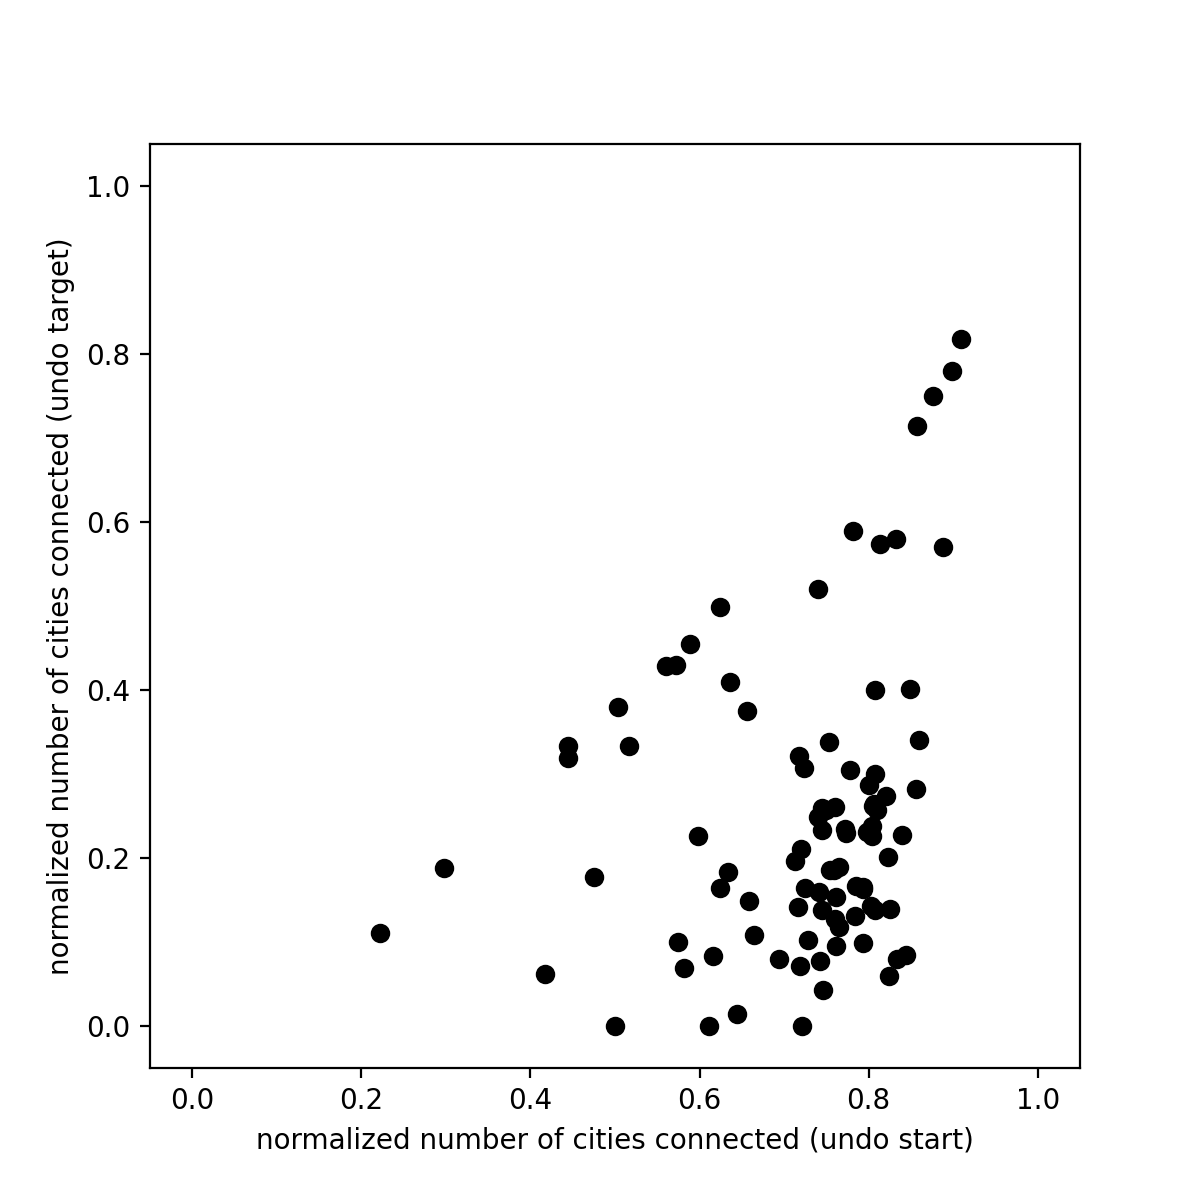

Text(0, 0.5, 'normalized number of cities connected (undo target)')

In [49]:
# only scatter plot
%matplotlib notebook

fig, ax = plt.subplots(figsize=(6, 6))
offset_ = .05# offset for better visualization
ax.set_xlim(0-offset_,1+offset_)
ax.set_ylim(0-offset_,1+offset_)
plt.scatter(str_ct_, end_ct_,color=[0,0,0])
plt.xlabel('normalized number of cities connected (undo start)')
plt.ylabel('normalized number of cities connected (undo target)')

## 1.2 Scatter plot (every data points)

In [50]:
end_ct = np.array(end_ct)
str_ct = np.array(str_ct)

str_ct = str_ct[~np.isnan(str_ct)]
end_ct = end_ct[~np.isnan(end_ct)]

# ind = np.argsort(str_ct - end_ct)
# ind = np.argsort(str_ct)
ind = np.argsort(end_ct)
#     plt.plot([str_ct[ind[i]], end_ct[ind[i]]], [i,i], 'k.--', linewidth=.1)

<IPython.core.display.Javascript object>


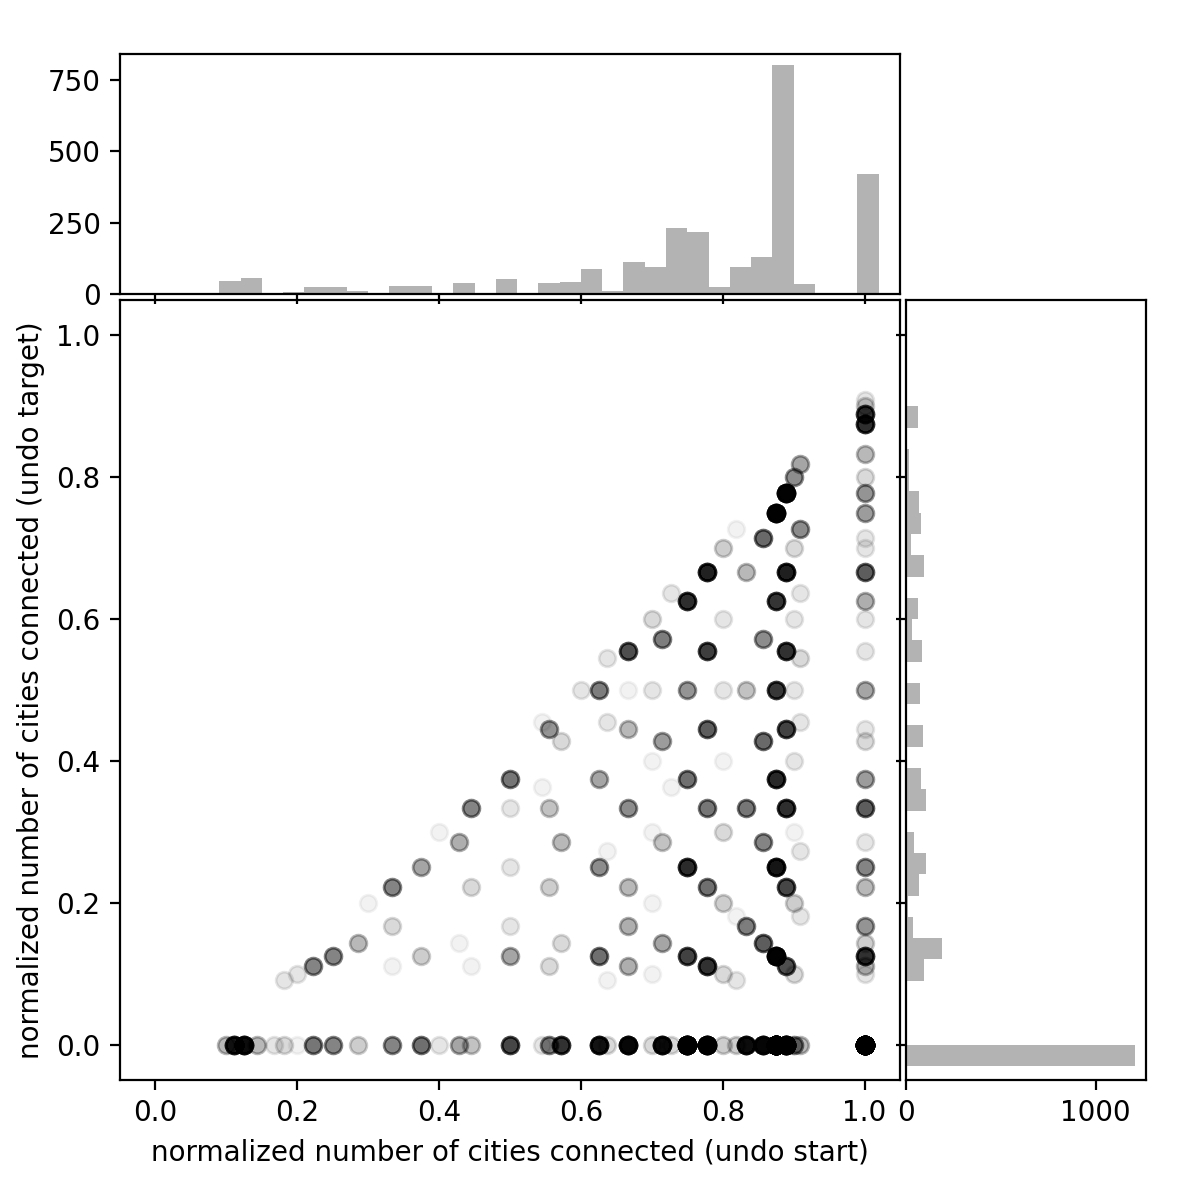

In [52]:
%matplotlib notebook
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(6, 6))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
offset_ = .05 # offset for better visualization
ax.set_xlim(0,1+offset_)
ax.set_ylim(0,1+offset_)
ax_histx.set_xlim(0-offset_,1+offset_)
ax_histy.set_ylim(0-offset_,1+offset_)
# use the previously defined function
scatter_hist(str_ct, end_ct, ax, ax_histx, ax_histy, alpha=0.05)

## 2. histogram of the position of branching node (similar to undo target, but not counting every visit)

<IPython.core.display.Javascript object>


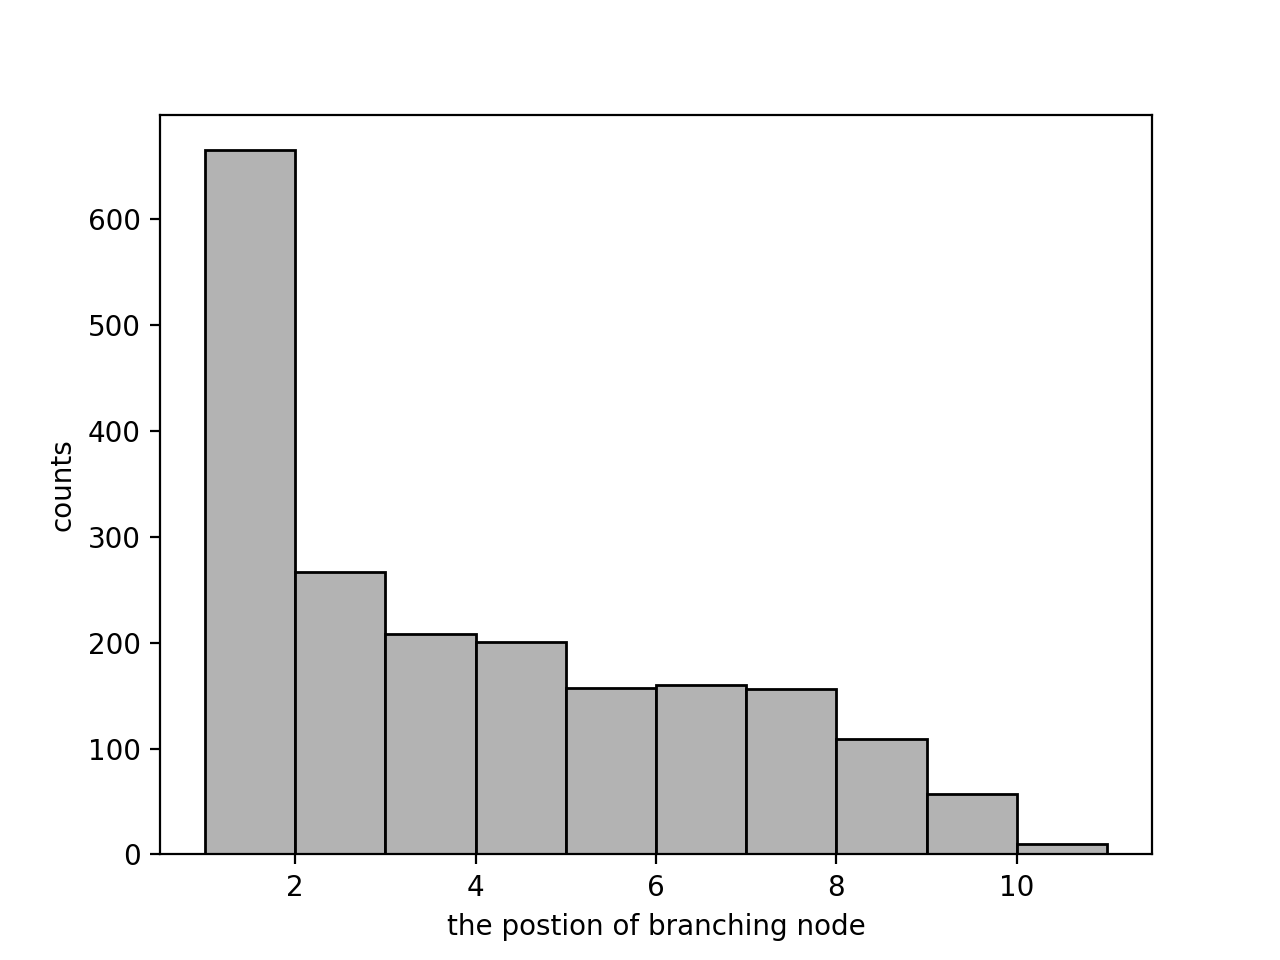

In [53]:
pos_branching = data_choice_level[data_choice_level['branchingFirst']==True]['currNumCities']

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(pos_branching,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('the postion of branching node') 
plt.show()

## 3. number of visits to branching node

<IPython.core.display.Javascript object>


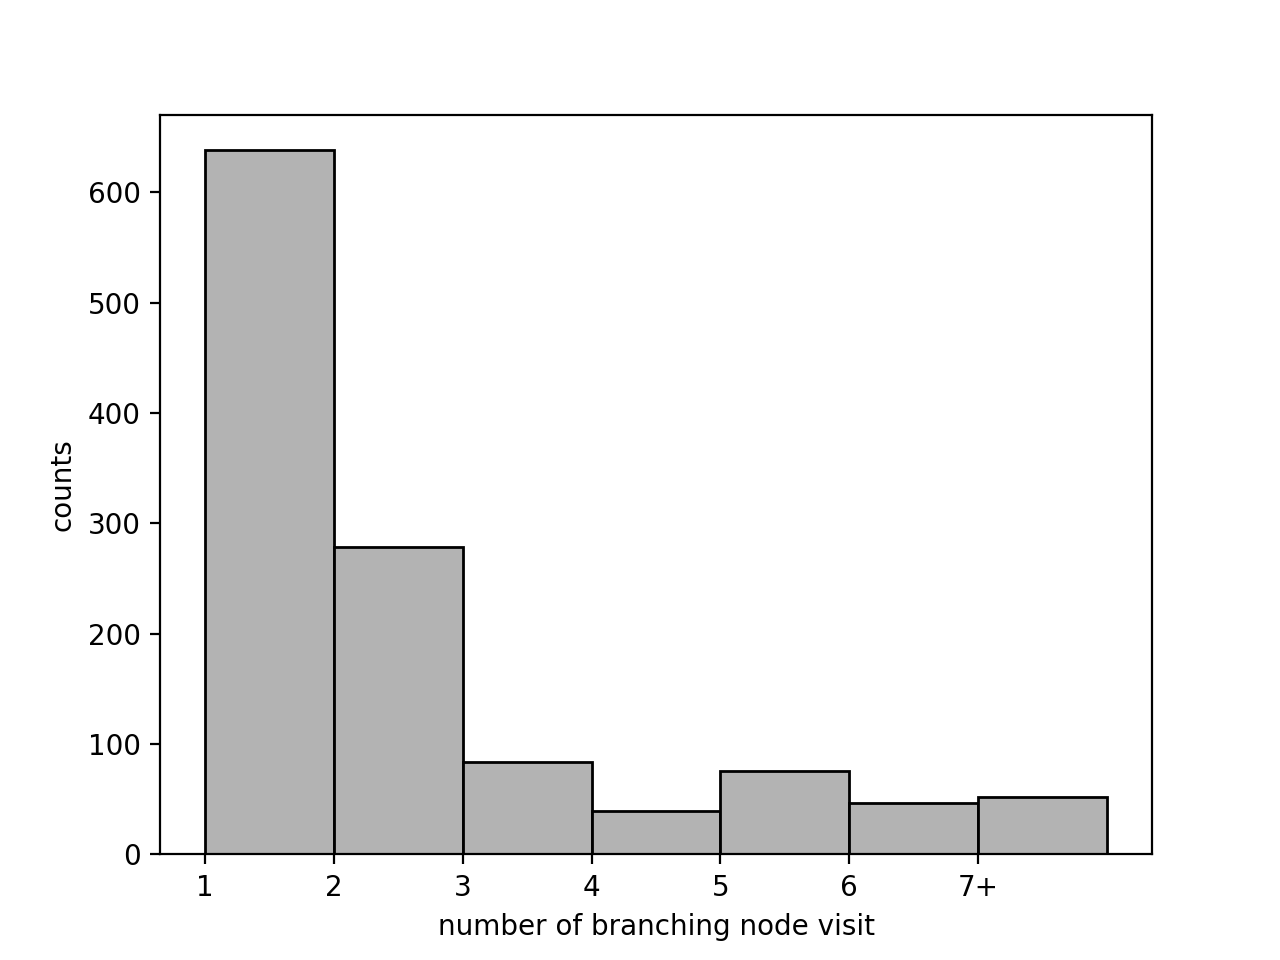

In [55]:
each_trial = data_choice_level[data_choice_level['condition']==1].groupby(["subjects","puzzleID"])
n_undotarget_visit = each_trial["branching"].count()
n_undotarget_visit

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(n_undotarget_visit,
        color = (.7,.7,.7), 
        bins = [2,3,4,5,6,7,8,9],
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('number of branching node visit') 
axs.set_xticks([2,3,4,5,6,7,8])
axs.set_xticklabels(["1","2","3","4","5","6","7+"])
plt.show()

## Undoing results in a different path?

### 1. Resulting in the same city?

In [56]:
undo_same_diff = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_same_diff_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        same_puzzle = 0
        diff_puzzle = 0
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
     
        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        
        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx)
        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx)
        
        undo_same_diff_puzzle.append([same_puzzle, diff_puzzle])
    undo_same_diff_puzzle =  np.array(undo_same_diff_puzzle)
    undo_same_diff_puzzle =  np.sum(undo_same_diff_puzzle,axis=0)

    undo_same_diff.append(undo_same_diff_puzzle)
    
undo_same_diff = np.array(undo_same_diff)

In [57]:
# exclude some never undoing subjects
undo_same_diff = undo_same_diff[np.where(np.sum(np.array(undo_same_diff),axis=1)!=0),:]
undo_same_diff = undo_same_diff.squeeze()
undo_same_diff_p = undo_same_diff/ np.sum(undo_same_diff,axis = 1)[:,None]

<IPython.core.display.Javascript object>


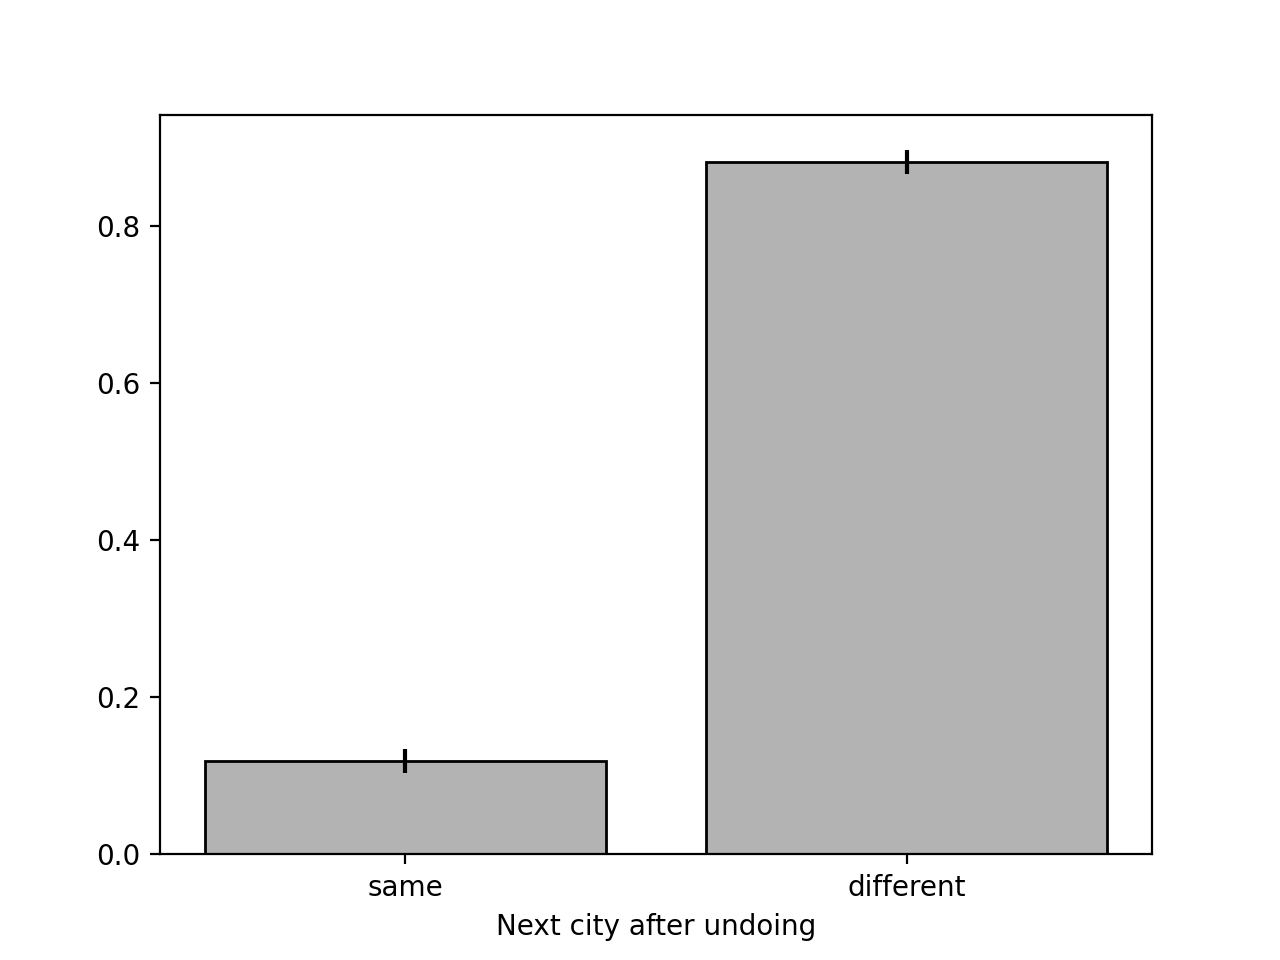

Text(0.5, 0, 'Next city after undoing')

In [58]:
%matplotlib notebook

plt.figure()
plt.bar(range(2), np.mean(undo_same_diff_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(undo_same_diff_p,axis = 0)/np.sqrt(undo_same_diff_p.shape[0]))
plt.xticks([0,1], ['same','different'])
plt.xlabel('Next city after undoing')

### 1.1 Result in the same city (separate for undo target is start city or not)

In [ ]:
undo_same_diff_start = [] # whether it is a start city
undo_same_diff_nostart = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    
    undo_same_diff_puzzle_start = []
    undo_same_diff_puzzle_nostart = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
    
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)].index  
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index

        idxx_start = np.array(dat_sbj_pzi["choice"][lastUndo_idx_start-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx_start+1])
        diff_puzzle_start = np.sum(idxx_start)
        idxx_start = np.array(dat_sbj_pzi["choice"][lastUndo_idx_start-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx_start+1])
        same_puzzle_start = np.sum(idxx_start)
        
        idxx_nostart = np.array(dat_sbj_pzi["choice"][lastUndo_idx_nostart-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx_nostart+1])
        diff_puzzle_nostart = np.sum(idxx_nostart)
        idxx_nostart = np.array(dat_sbj_pzi["choice"][lastUndo_idx_nostart-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx_nostart+1])
        same_puzzle_nostart = np.sum(idxx_nostart)
        
        undo_same_diff_puzzle_start.append([same_puzzle_start, diff_puzzle_start]) # one number for each puzzle
        undo_same_diff_puzzle_nostart.append([same_puzzle_nostart, diff_puzzle_nostart])
        
    undo_same_diff_puzzle_start =  np.array(undo_same_diff_puzzle_start) # one number for each subject
    undo_same_diff_puzzle_start =  np.sum(undo_same_diff_puzzle_start,axis=0) 
    undo_same_diff_puzzle_nostart =  np.array(undo_same_diff_puzzle_nostart)
    undo_same_diff_puzzle_nostart =  np.sum(undo_same_diff_puzzle_nostart,axis=0)
    
    undo_same_diff_start.append(undo_same_diff_puzzle_start)
    undo_same_diff_nostart.append(undo_same_diff_puzzle_nostart)
    
undo_same_diff_start = np.array(undo_same_diff_start)
undo_same_diff_nostart = np.array(undo_same_diff_nostart)

In [134]:
# exclude some never undoing subjects
undo_same_diff_start = undo_same_diff_start[np.where(np.sum(np.array(undo_same_diff_start),axis=1)!=0),:]
undo_same_diff_start = undo_same_diff_start.squeeze()
undo_same_diff_start_p = undo_same_diff_start/ np.sum(undo_same_diff_start,axis = 1)[:,None]

undo_same_diff_nostart = undo_same_diff_nostart[np.where(np.sum(np.array(undo_same_diff_nostart),axis=1)!=0),:]
undo_same_diff_nostart = undo_same_diff_nostart.squeeze()
undo_same_diff_nostart_p = undo_same_diff_nostart/ np.sum(undo_same_diff_nostart,axis = 1)[:,None]

undo_same_diff_p_mean = np.concatenate((np.mean(undo_same_diff_start_p,axis=0), np.mean(undo_same_diff_nostart_p,axis=0)), axis=None)
undo_same_diff_p_yerr = np.concatenate((np.std(undo_same_diff_start_p,axis = 0)/np.sqrt(undo_same_diff_start_p.shape[0]), 
                                        np.std(undo_same_diff_nostart_p,axis = 0)/np.sqrt(undo_same_diff_nostart_p.shape[0])), axis=None)

<IPython.core.display.Javascript object>


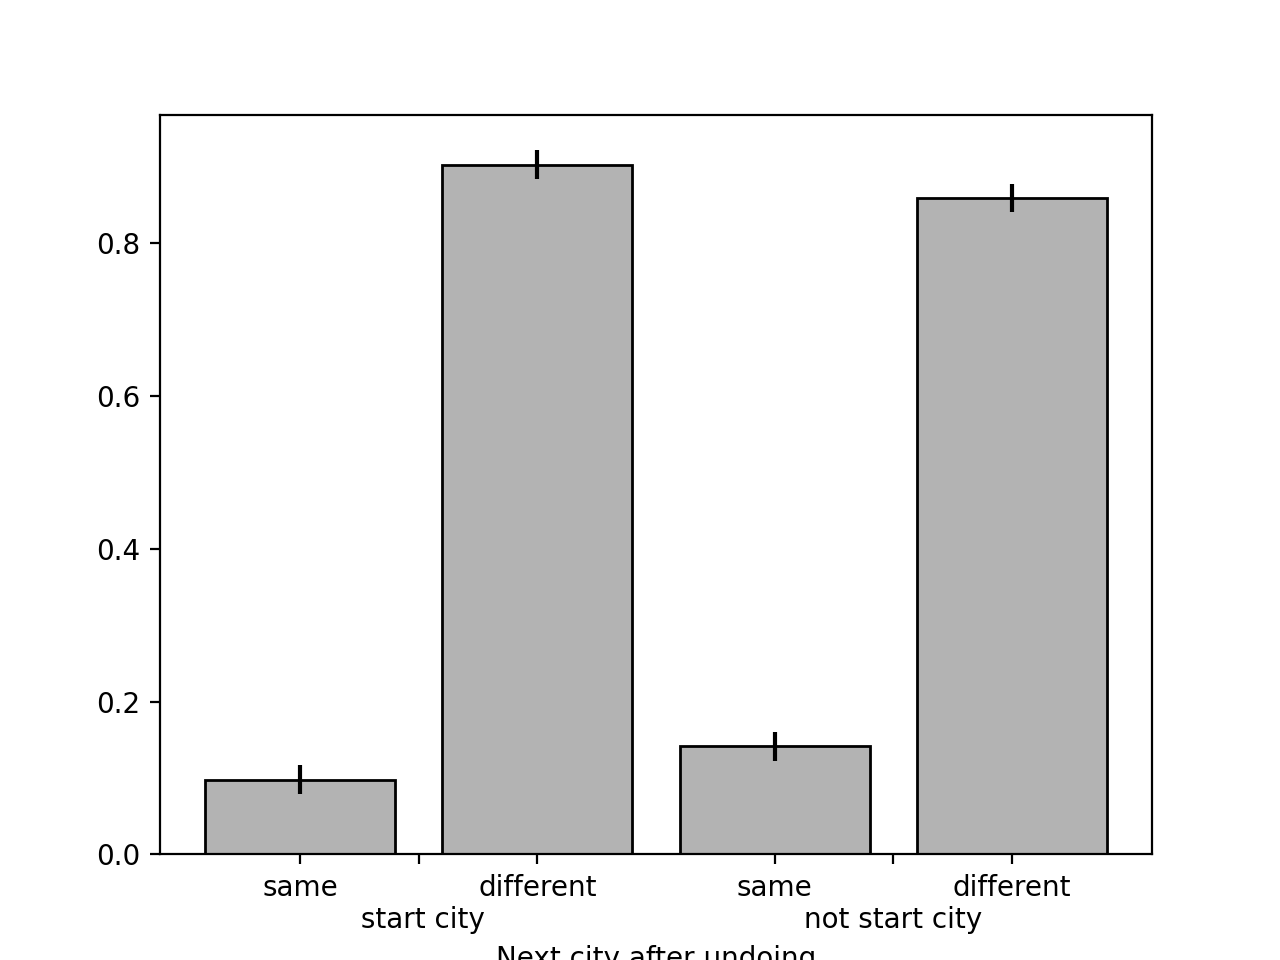

Text(0.5, 0, 'Next city after undoing')

In [135]:
%matplotlib notebook

plt.figure()
plt.bar([0,1,2,3], undo_same_diff_p_mean,
        color=[.7,.7,.7], edgecolor = 'k',
        yerr=undo_same_diff_p_yerr
       )
plt.xticks([0,0.5,1, 2,2.5,3], ['same','\n start city','different','same','\nnot start city','different'])
plt.xlabel('Next city after undoing')

### 2. Results in same path (total overlap in path, the undo is unnecessary)?

In [62]:
undo_for_better = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_for_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()           

        firstUndo_idx_ = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        firstUndo_idx_ = firstUndo_idx_.to_list()
#         firstUndo_idx_ = (firstUndo_idx_ - 1).to_list()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        lastUndo_idx = lastUndo_idx.to_list()

        submit_idx = dat_sbj_pzi[dat_sbj_pzi["submit"]==1].index
        submit_idx = submit_idx.to_list()

        lastUndo_idx_ = [0]
        lastUndo_idx_.extend(lastUndo_idx) # put 0 at the beginning
        firstUndo_idx = submit_idx.copy()
        firstUndo_idx_.extend(firstUndo_idx) # put submit at the end
        
        for tr in range(len(firstUndo_idx_)-1):
            Prev_seq = dat_sbj_pzi['choice'][lastUndo_idx_[tr]:firstUndo_idx_[tr]].to_list()
            Curr_seq = dat_sbj_pzi['choice'][lastUndo_idx_[tr+1]:firstUndo_idx_[tr+1]].to_list()
#             print('*'*10)
#             print(tr)
#             print(Prev_seq)
#             print(Curr_seq)
#             print('*'*10)
#             print(Prev_seq)
#             print(Curr_seq)
#             undo_target = Curr_seq[0]
#             print(undo_target)
            # if a participant undid more than the length of the previous undoing sequence
            if dat_sbj_pzi['currNumCities'][lastUndo_idx_[tr]]>dat_sbj_pzi['currNumCities'][lastUndo_idx_[tr+1]]: 
                # then it is simply whether the previous undoing sequence is in the current undoing sequence
                if np.all(np.isin(Prev_seq, Curr_seq)):
                    undo_for_puzzle.append(1)
                else:
                    undo_for_puzzle.append(0)
            else:
                # first find undo target
                undo_target = Curr_seq[0]
                Prev_seq_temp = Prev_seq[np.argwhere(np.array(Prev_seq)==undo_target).squeeze():]
                len_frag = min(len(Prev_seq_temp), len(Curr_seq))
                Prev_seq_temp = Prev_seq_temp[:len_frag]
                Curr_seq_temp = Curr_seq[:len_frag]

                if np.all(Prev_seq_temp==Curr_seq_temp):
                    undo_for_puzzle.append(1)
                else:
                    undo_for_puzzle.append(0)
#             print('hup')
    undo_for_puzzle =  np.array(undo_for_puzzle)
    undo_for_better.append([np.sum(undo_for_puzzle==0), np.sum(undo_for_puzzle==1)])
undo_for_better = np.array(undo_for_better)

In [63]:
# exclude some never undoing subjects
undo_for_better = undo_for_better[np.where(np.sum(np.array(undo_for_better),axis=1)!=0),:]
undo_for_better = undo_for_better.squeeze()
undo_for_better_p = undo_for_better/ np.sum(undo_for_better,axis = 1)[:,None]

<IPython.core.display.Javascript object>


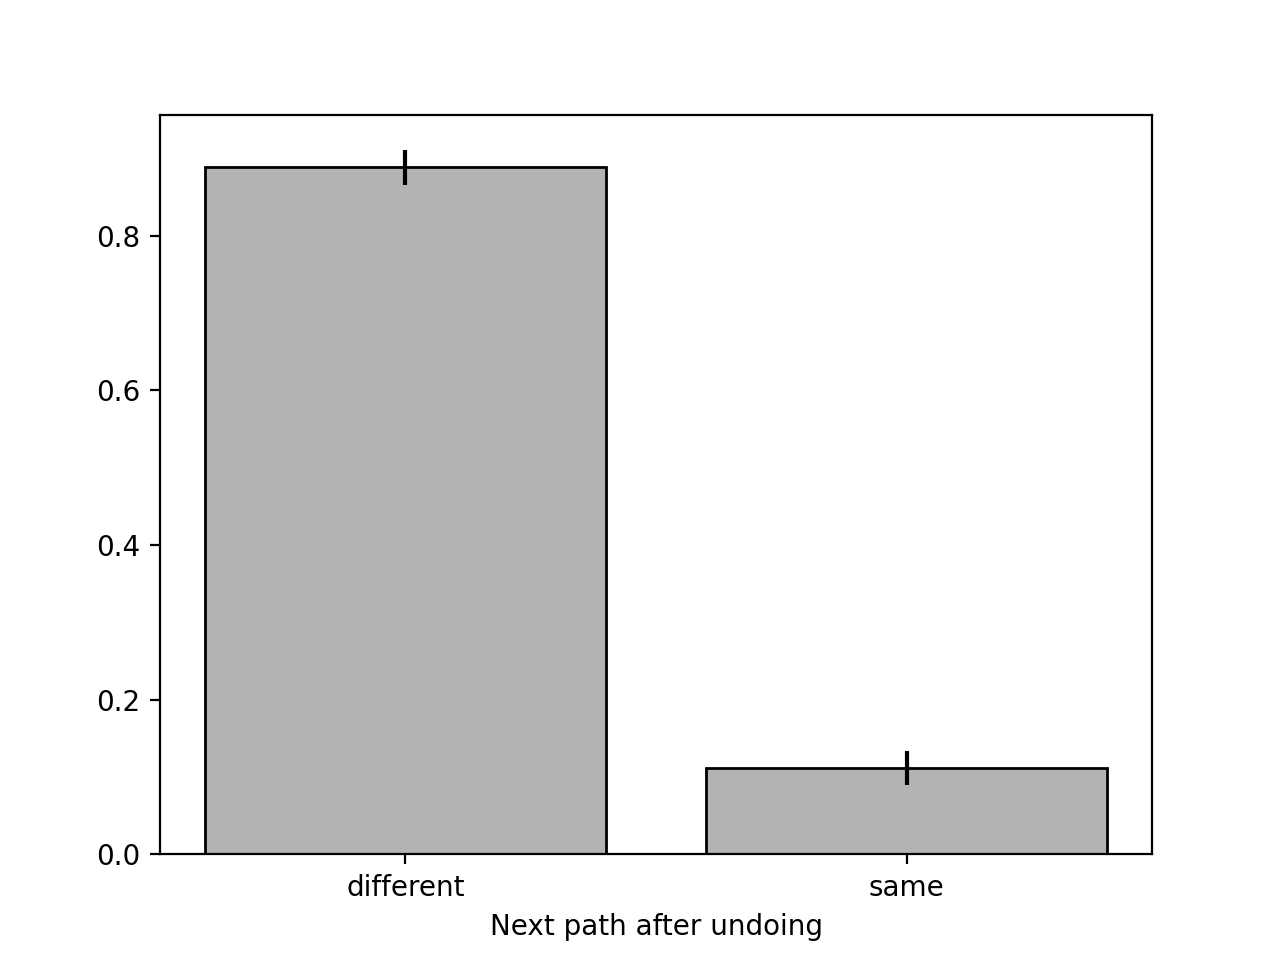

Text(0.5, 0, 'Next path after undoing')

In [64]:
%matplotlib notebook
plt.figure()
plt.bar(range(2), np.mean(undo_for_better_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(undo_for_better_p,axis = 0)/np.sqrt(undo_for_better_p.shape[0]))
plt.xticks([0,1], ['different','same'])
plt.xlabel('Next path after undoing')

### 3. count number of visits to a state (not undo target)

In [65]:
importer = JsonImporter()
visit = []
for ti in range(len(undo_tree)): # loop through trials
    root = importer.import_(undo_tree[ti])
    
    for node in PreOrderIter(root): # loop through the tree
        n_child = len(node.children)
        visit.append(node.visit)

visit.count(2)

1849

# Undo target

## 1. Whether the undo target is start city may be dependent on the accumulated error

In [66]:
accu_error = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    accu_error_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
     
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)].index
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index
        
        start_idx = np.where(np.isin(lastUndo_idx,lastUndo_idx_start))
        firstUndo_idx_start = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index[start_idx]
        nostart_idx = np.where(np.isin(lastUndo_idx,lastUndo_idx_nostart))
        firstUndo_idx_nostart = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index[nostart_idx]
        
        df_beforeUndo_start = dat_sbj_pzi.loc[firstUndo_idx_start-1,:]
        accu_severity_error_start = df_beforeUndo_start['allMAS'] - df_beforeUndo_start['currMas']
        
        df_beforeUndo_nostart = dat_sbj_pzi.loc[firstUndo_idx_nostart-1,:]
        accu_severity_error_nostart = df_beforeUndo_nostart['allMAS'] - df_beforeUndo_nostart['currMas']
        
        accu_error_puzzle.append([np.nanmean(accu_severity_error_start),np.nanmean(accu_severity_error_nostart)])
        
    accu_error_puzzle =  np.array(accu_error_puzzle)
    accu_error_puzzle =  np.nanmean(accu_error_puzzle,axis=0)

    accu_error.append(accu_error_puzzle)
    
accu_error = np.array(accu_error)

<ipython-input-66-384be2200061>:29: RuntimeWarning: Mean of empty slice
  accu_error_puzzle =  np.nanmean(accu_error_puzzle,axis=0)


<IPython.core.display.Javascript object>


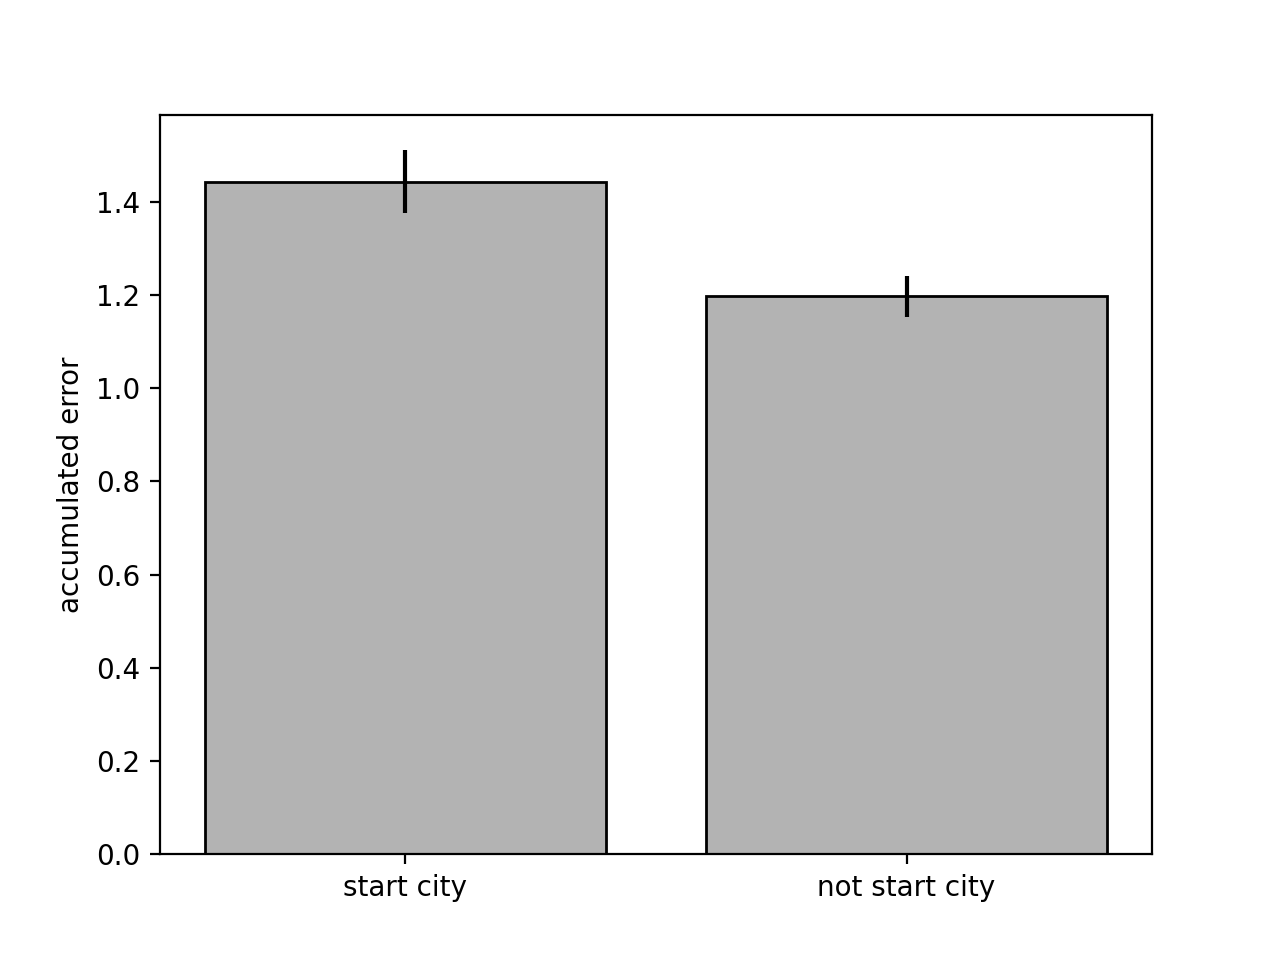

Text(0, 0.5, 'accumulated error')

In [67]:
%matplotlib notebook
plt.figure()
plt.bar(range(2), np.nanmean(accu_error,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.nanstd(accu_error,axis = 0)/np.sqrt(accu_error.shape[0]))
plt.xticks([0,1], ['start city','not start city'])
plt.ylabel('accumulated error')

## 2. compare 3 states: before-undo target state, undo target state and after-undo target state if undo target is not the start city

In [68]:
accu_error_3 = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    accu_error_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        accu_severity_error_after = []
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
     
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index
        
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = df_undoTarget['allMAS'] - df_undoTarget['currMas']
        
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas']
        
        undoTarget_after_choice = [eval(path)[:-1] for path in list(df_undoTarget['path'])]
        try: 
            if len(undoTarget_after_choice)!=0:
                for item in undoTarget_after_choice:
                    after_path = str(item)
                    df_after = dat_sbj_pzi[dat_sbj_pzi["path"]==after_path].iloc[0]
                    accu_severity_error_after.append((df_after['allMAS'] - df_after['currMas']))
        except: 
            accu_severity_error_after.append(None)
        
        accu_error_puzzle.append([np.nanmean(accu_severity_error_before),np.nanmean(accu_severity_error),np.nanmean(accu_severity_error_after)])

    accu_error_puzzle =  np.array(accu_error_puzzle)
    accu_error_puzzle =  np.nanmean(accu_error_puzzle,axis=0)

    accu_error_3.append(accu_error_puzzle)
    
accu_error_3 = np.array(accu_error_3)


<ipython-input-68-10ef6353e029>:33: RuntimeWarning: Mean of empty slice
  accu_error_puzzle.append([np.nanmean(accu_severity_error_before),np.nanmean(accu_severity_error),np.nanmean(accu_severity_error_after)])
<ipython-input-68-10ef6353e029>:36: RuntimeWarning: Mean of empty slice
  accu_error_puzzle =  np.nanmean(accu_error_puzzle,axis=0)


<IPython.core.display.Javascript object>


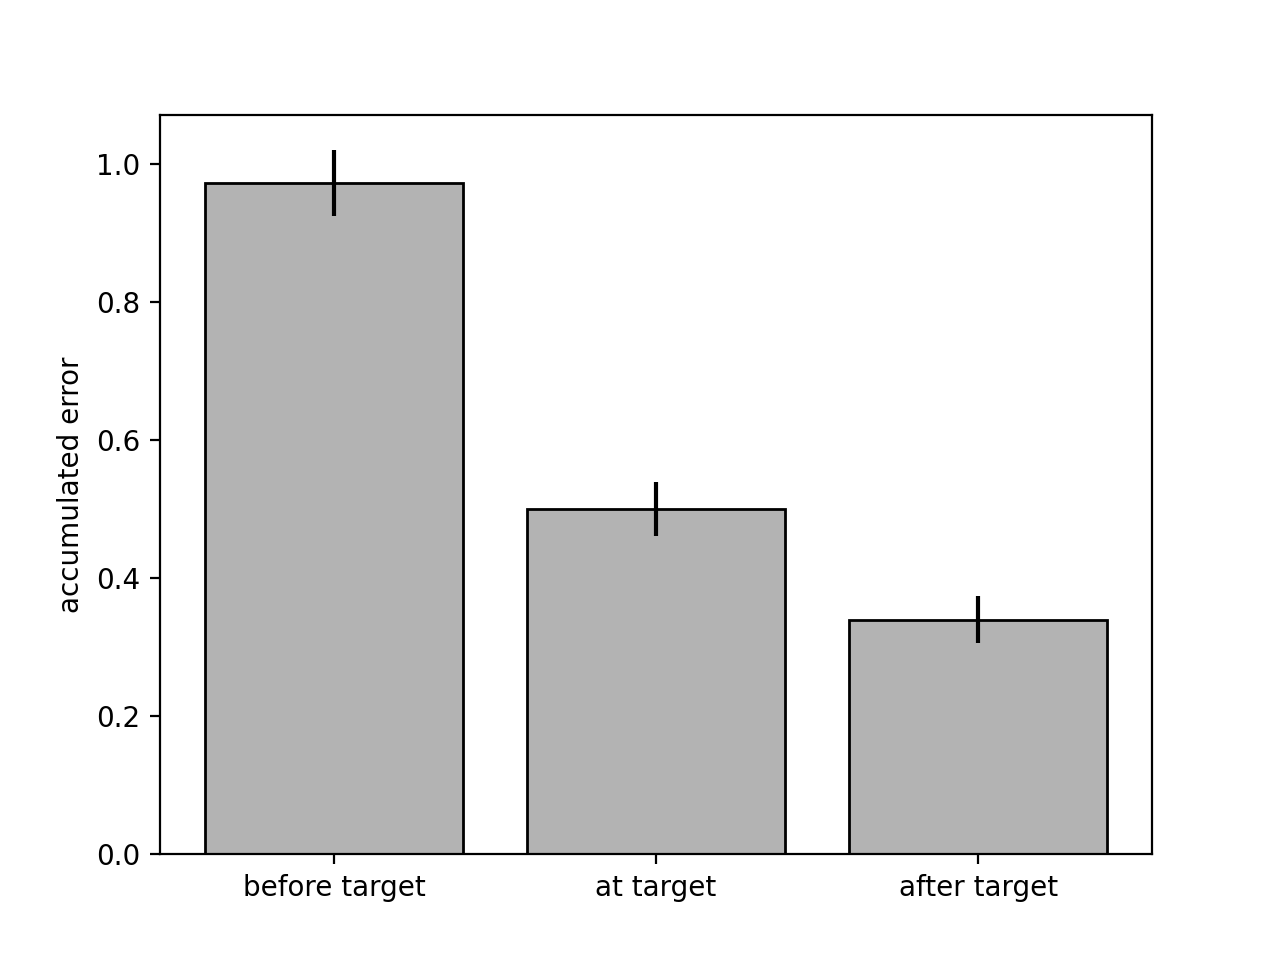

Text(0, 0.5, 'accumulated error')

In [69]:
%matplotlib notebook
plt.figure()
plt.bar(range(3), np.nanmean(accu_error_3,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.nanstd(accu_error_3,axis = 0)/np.sqrt(accu_error.shape[0]))
plt.xticks([0,1,2], ['before target undo one less','at target','after target undo one more'])
plt.ylabel('accumulated error')

## Check the position where they "first" made errors, and whether undo target is that


### 1. undo target is not the start

In [112]:
accu_error_3 = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    accu_error_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
     
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index
        
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0:
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0):
                category[i] = 1
            elif accu_severity_error[i] > 0:
                category[i] = 2
        
        accu_error_puzzle.extend(category)
    accu_error_puzzle =  np.array(accu_error_puzzle)
    accu_error_3.append([np.sum(accu_error_puzzle==0), np.sum(accu_error_puzzle==1) ,np.sum(accu_error_puzzle==2)])
    
accu_error_3 = np.array(accu_error_3)


In [113]:
# exclude some never undoing subjects
accu_error_3 = accu_error_3[np.where(np.sum(np.array(accu_error_3),axis=1)!=0),:]
accu_error_3 = accu_error_3.squeeze()
accu_error_3_p = accu_error_3/ np.sum(accu_error_3,axis = 1)[:,None]

<IPython.core.display.Javascript object>


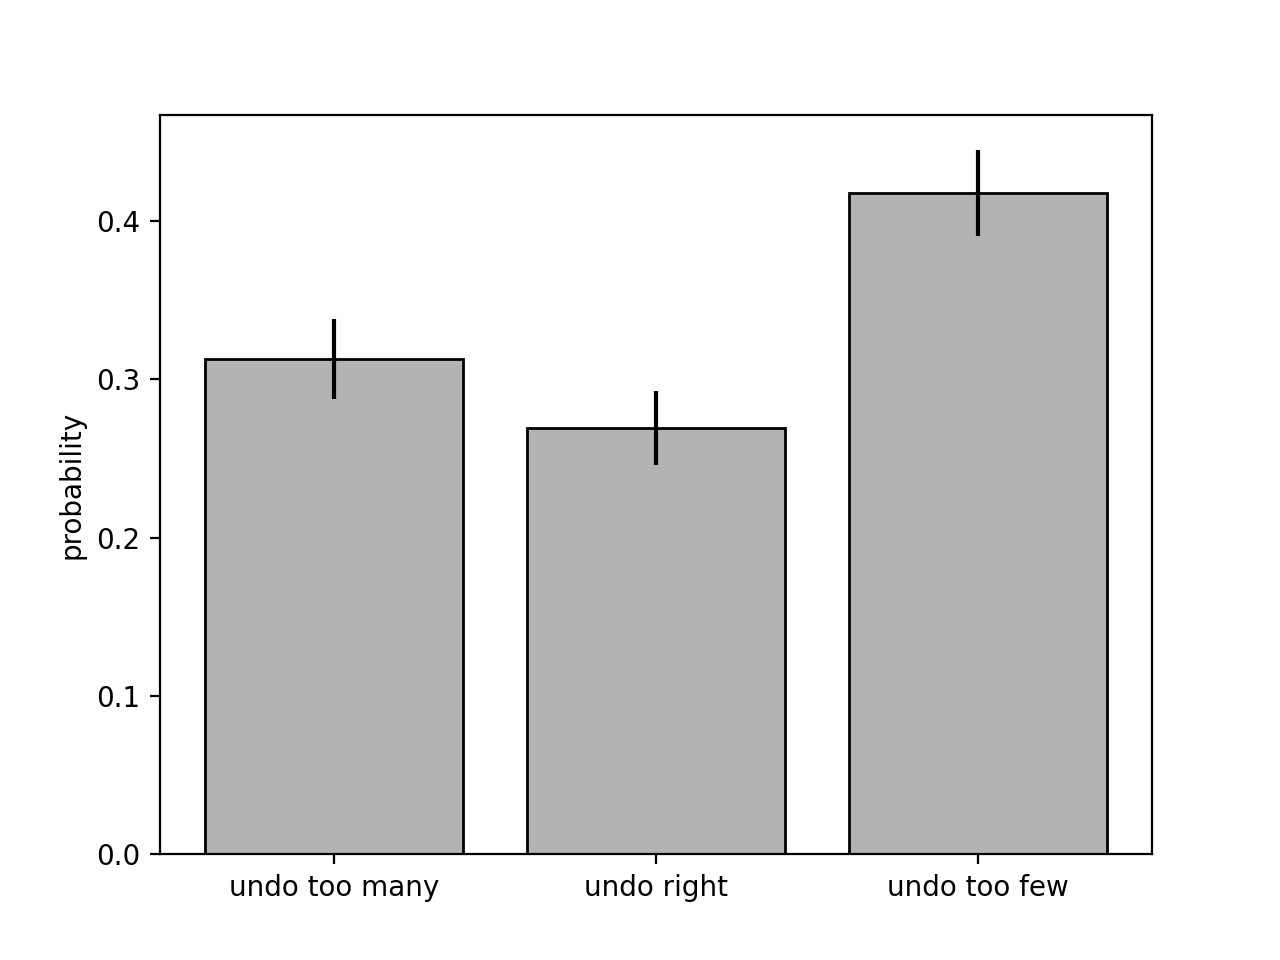

Text(0, 0.5, 'probability')

In [126]:
%matplotlib notebook
plt.figure()
plt.bar(range(3), np.mean(accu_error_3_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(accu_error_3_p,axis = 0)/np.sqrt(accu_error_3_p.shape[0]))
plt.xticks([0,1,2], ['undo too many','undo right','undo too few'])
plt.ylabel('probability')

### 1.2 When undo target is the start 

In [141]:
accu_error_2 = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    accu_error_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
     
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)].index

        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0:
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0):
                category[i] = 1
        
        accu_error_puzzle.extend(category)

        
    accu_error_puzzle =  np.array(accu_error_puzzle)
    accu_error_2.append([np.sum(accu_error_puzzle==0), np.sum(accu_error_puzzle==1)])
    
accu_error_2 = np.array(accu_error_2)

In [142]:
# exclude some never undoing subjects
accu_error_2 = accu_error_2[np.where(np.sum(np.array(accu_error_2),axis=1)!=0),:]
accu_error_2 = accu_error_2.squeeze()
accu_error_2_p = accu_error_2/ np.sum(accu_error_2,axis = 1)[:,None]

<IPython.core.display.Javascript object>


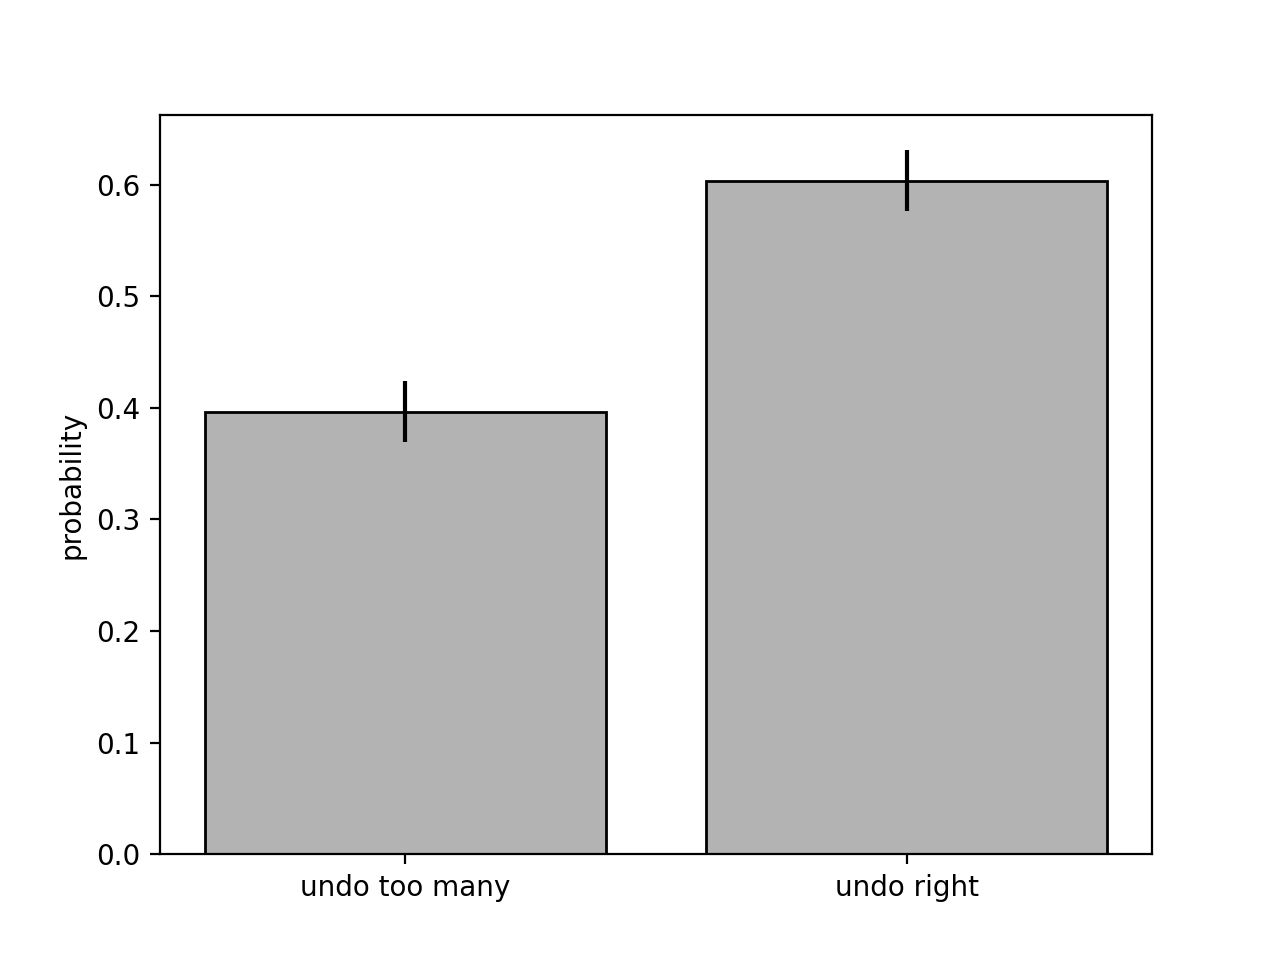

Text(0, 0.5, 'probability')

In [144]:
%matplotlib notebook
plt.figure()
plt.bar(range(2), np.mean(accu_error_2_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(accu_error_2_p,axis = 0)/np.sqrt(accu_error_2_p.shape[0]))
plt.xticks([0,1], ['undo too many','undo right'])
plt.ylabel('probability')

# After an undo or sequence of undos, how often do people actually choose a better [move]?! 

### 1. TODO: only if they choose different paths

In [72]:
undo_for_better = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_for_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx-1] # the mas of the state before undo
        
        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx+1] # the mas of the state after undo
        
        # I think it doesn't mean it choose different path, it means at least once the chosen city is different after undo
        if np.any(np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])):
            
            idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
            undo_for_puzzle.extend(np.sign(np.array(path_af_undo[idxx]) - np.array(path_bf_undo[idxx])))
#         else:
#             print('hup')
    undo_for_puzzle =  np.array(undo_for_puzzle)
    undo_for_better.append([np.sum(undo_for_puzzle<0), np.sum(undo_for_puzzle==0) ,np.sum(undo_for_puzzle>0)])
undo_for_better = np.array(undo_for_better)

In [73]:
# exclude some never undoing subjects
undo_for_better = undo_for_better[np.where(np.sum(np.array(undo_for_better),axis=1)!=0),:]
undo_for_better = undo_for_better.squeeze()
undo_for_better_p = undo_for_better/ np.sum(undo_for_better,axis = 1)[:,None]

<IPython.core.display.Javascript object>


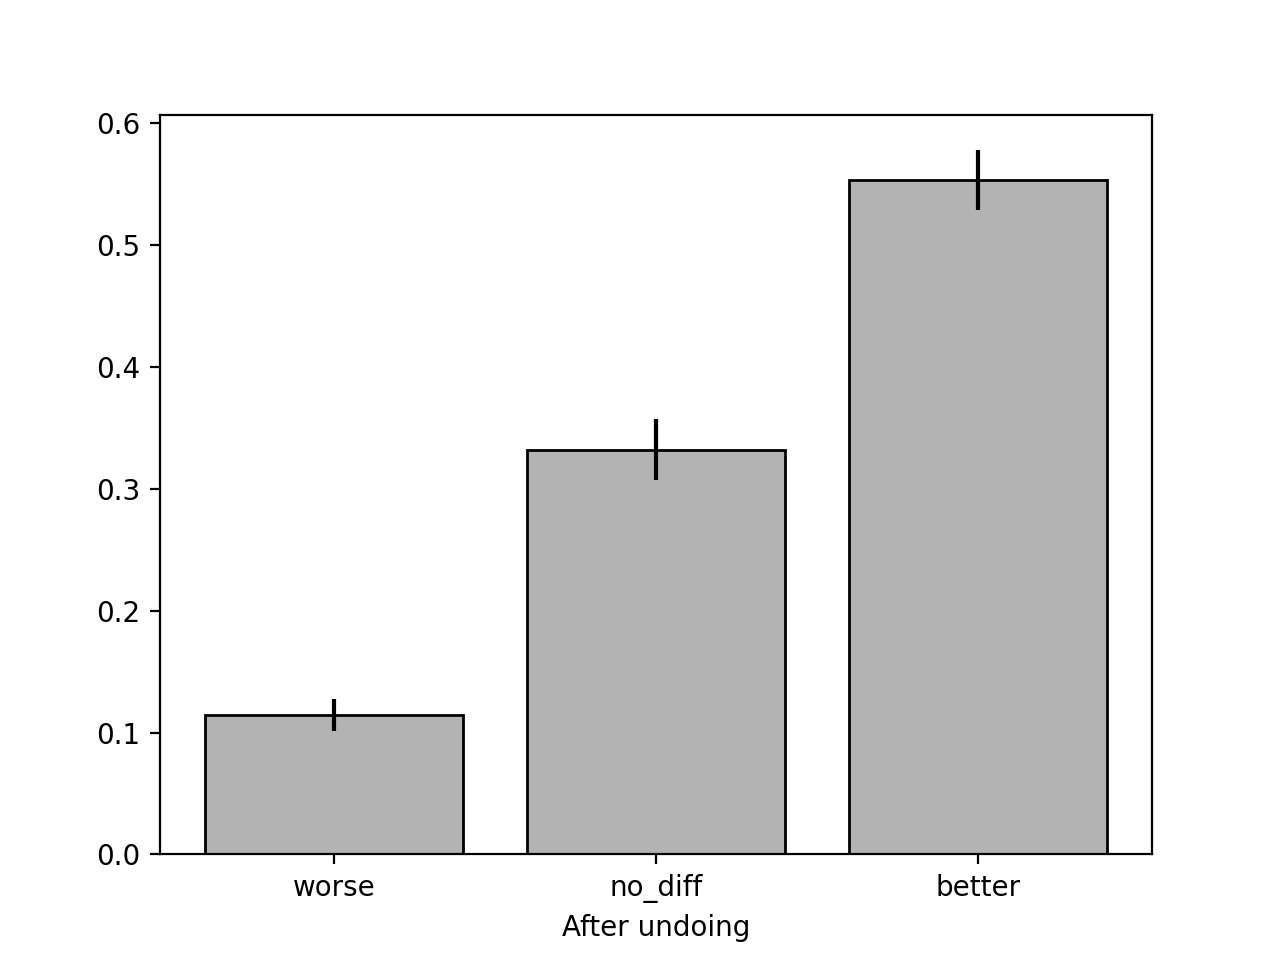

Text(0.5, 0, 'After undoing')

In [74]:
%matplotlib notebook
plt.figure()
plt.bar(range(3), np.mean(undo_for_better_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(undo_for_better_p,axis = 0)/np.sqrt(undo_for_better_p.shape[0]))
plt.xticks([0,1,2], ['worse','no_diff','better'])
plt.xlabel('After undoing')

### 2. all cases (including undoing to the same paths)

In [13]:
undo_for_better = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_for_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx-1]
        
        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx+1]
        
        change = np.sign(np.array(path_af_undo) - np.array(path_bf_undo))
        category = [np.nan]*len(change)
        
        for i in range(len(change)): 
            if change[i] < 0:
                category[i] = 0
            elif (change[i] == 0)& (dat_sbj_pzi["choice"][firstUndo_idx[i]-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx[i]+1]):
                category[i] = 1
            elif (change[i] == 0)& (dat_sbj_pzi["allMAS"][firstUndo_idx[i]-1] == dat_sbj_pzi["currMas"][firstUndo_idx[i]-1]):
                category[i] = 2
            elif change[i] > 0:
                category[i] = 3
        # only after undoing to a different path 
#         if np.any(np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])):
#             idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        undo_for_puzzle.extend(category)
#         else:
#             print('hup')
    undo_for_puzzle =  np.array(undo_for_puzzle)
    undo_for_better.append([np.sum(undo_for_puzzle==0), np.sum(undo_for_puzzle==1) ,np.sum(undo_for_puzzle==2), np.sum(undo_for_puzzle==3)])
undo_for_better = np.array(undo_for_better)

In [14]:
# exclude some never undoing subjects
undo_for_better = undo_for_better[np.where(np.sum(np.array(undo_for_better),axis=1)!=0),:]
undo_for_better = undo_for_better.squeeze()
undo_for_better_p = undo_for_better/ np.sum(undo_for_better,axis = 1)[:,None]

<IPython.core.display.Javascript object>


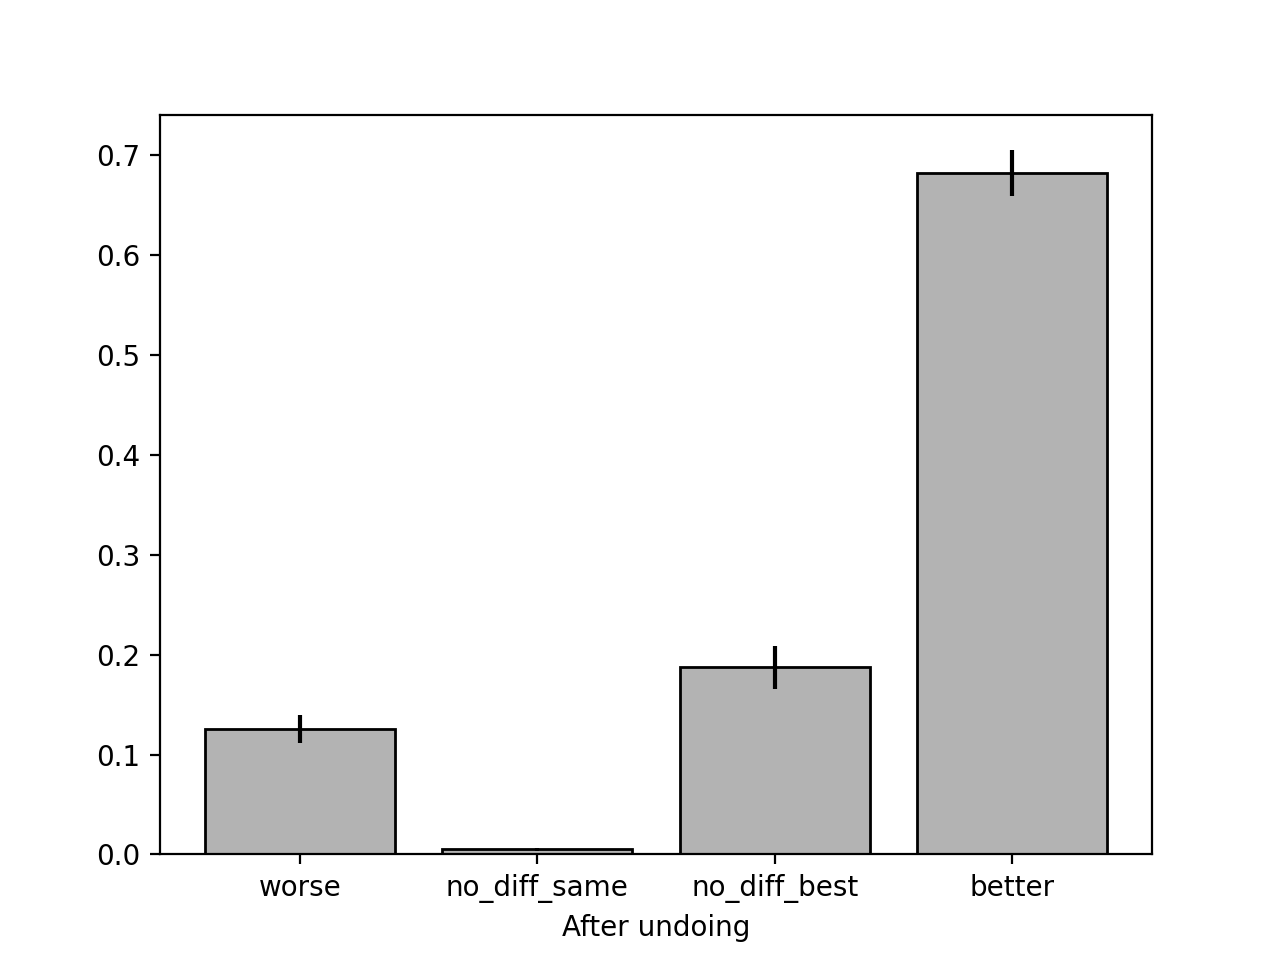

Text(0.5, 0, 'After undoing')

In [17]:
%matplotlib notebook
plt.figure()
plt.bar(range(4), np.mean(undo_for_better_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(undo_for_better_p,axis = 0)/np.sqrt(undo_for_better_p.shape[0]))
plt.xticks([0,1,2,3], ['worse','no_diff_same','no_diff_best','better'])
plt.xlabel('After undoing')

## leaf node bf/af undoing (After an undo or sequence of undos, how often do people actually choose a better [path])?!

### 1. Including going to the same path

In [76]:
undo_for_better = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_for_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx-1]
        firstUndo_idx = firstUndo_idx.to_list()
        
        submit_idx = dat_sbj_pzi[dat_sbj_pzi["submit"]==1].index
        submit_idx = submit_idx.to_list()
        
        firstUndo_idx.extend(submit_idx) 
        
        for i in range(len(firstUndo_idx)-1):
            undo_for_puzzle.append(dat_sbj_pzi["currMas"][firstUndo_idx[i+1]-1] - dat_sbj_pzi["currMas"][firstUndo_idx[i]-1])
    
#             print('hup')
    undo_for_puzzle =  np.array(undo_for_puzzle)
    undo_for_better.append([np.sum(undo_for_puzzle<0), np.sum(undo_for_puzzle==0) ,np.sum(undo_for_puzzle>0)])
undo_for_better = np.array(undo_for_better)

In [77]:
# exclude some never undoing subjects
undo_for_better = undo_for_better[np.where(np.sum(np.array(undo_for_better),axis=1)!=0),:]
undo_for_better = undo_for_better.squeeze()
undo_for_better_p = undo_for_better/ np.sum(undo_for_better,axis = 1)[:,None]

<IPython.core.display.Javascript object>


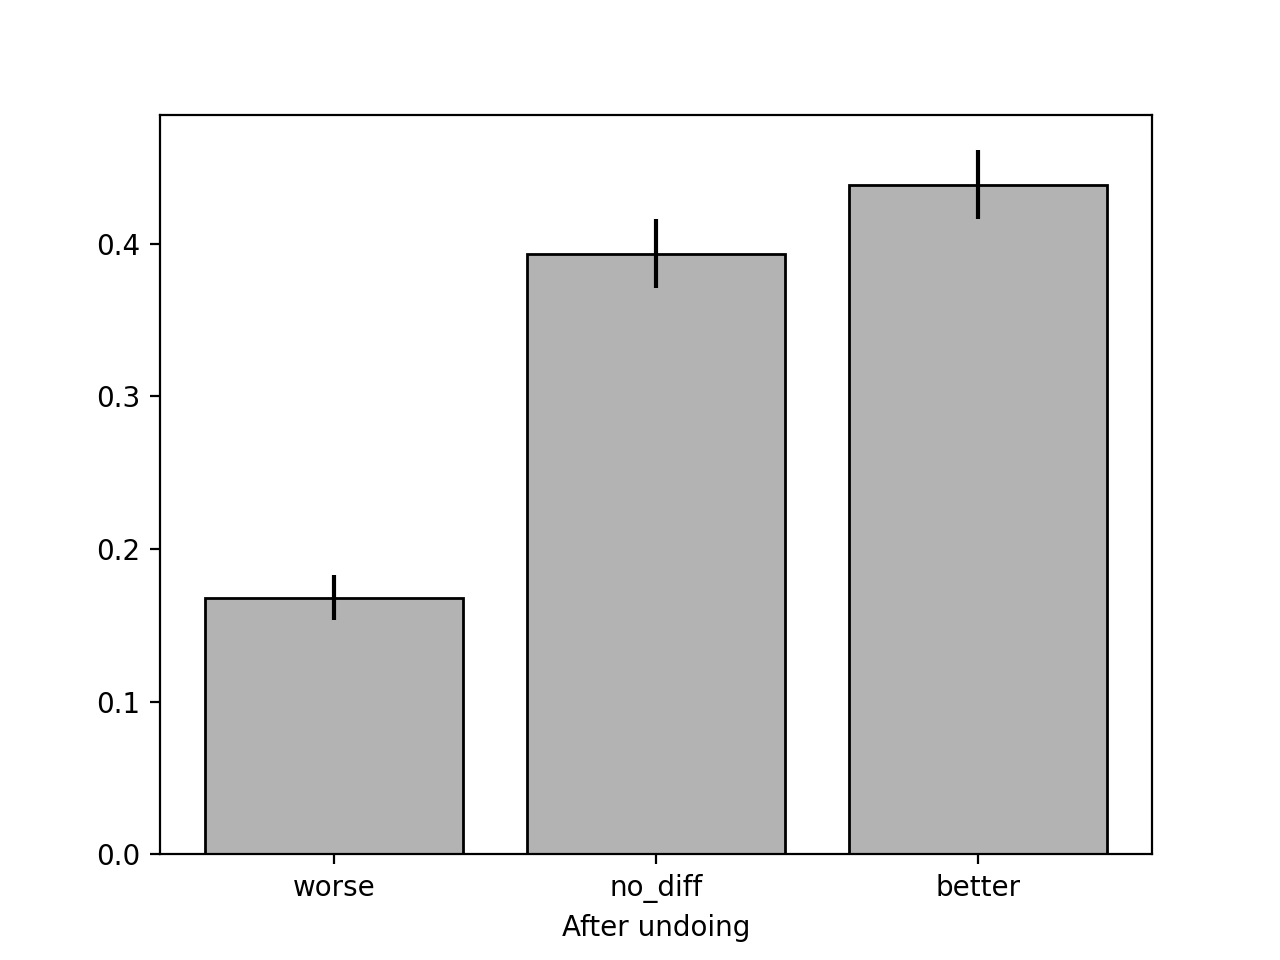

Text(0.5, 0, 'After undoing')

In [78]:
%matplotlib notebook
plt.figure()
plt.bar(range(3), np.mean(undo_for_better_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(undo_for_better_p,axis = 0)/np.sqrt(undo_for_better_p.shape[0]))
plt.xticks([0,1,2], ['worse','no_diff','better'])
plt.xlabel('After undoing')

## before undo or after undo, are they in a optimal path?

In [34]:
optimal_before_all = []
optimal_after_all = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    optimal_before = []
    optimal_after = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        path_bf_undo = (dat_sbj_pzi["allMAS"][firstUndo_idx-1] - dat_sbj_pzi["currMas"][firstUndo_idx-1])
        
        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        path_af_undo = (dat_sbj_pzi["allMAS"][lastUndo_idx+1] - dat_sbj_pzi["currMas"][lastUndo_idx+1])
        
        optimal_before.extend(path_bf_undo)
        optimal_after.extend(path_af_undo)

    optimal_before = np.array(optimal_before)
    optimal_after = np.array(optimal_after)
    
    optimal_before_all.append([np.sum(optimal_before>0), np.sum(optimal_before==0)])
    optimal_after_all.append([np.sum(optimal_after>0), np.sum(optimal_after==0)])
    
optimal_before_all = np.array(optimal_before_all)
optimal_after_all = np.array(optimal_after_all)

In [35]:
# exclude some never undoing subjects
optimal_before_all = optimal_before_all[np.where(np.sum(np.array(optimal_before_all),axis=1)!=0),:]
optimal_before_all = optimal_before_all.squeeze()
optimal_before_all_p = optimal_before_all/ np.sum(optimal_before_all,axis = 1)[:,None]

optimal_after_all = optimal_after_all[np.where(np.sum(np.array(optimal_after_all),axis=1)!=0),:]
optimal_after_all = optimal_after_all.squeeze()
optimal_after_all_p = optimal_after_all/ np.sum(optimal_after_all,axis = 1)[:,None]

<IPython.core.display.Javascript object>


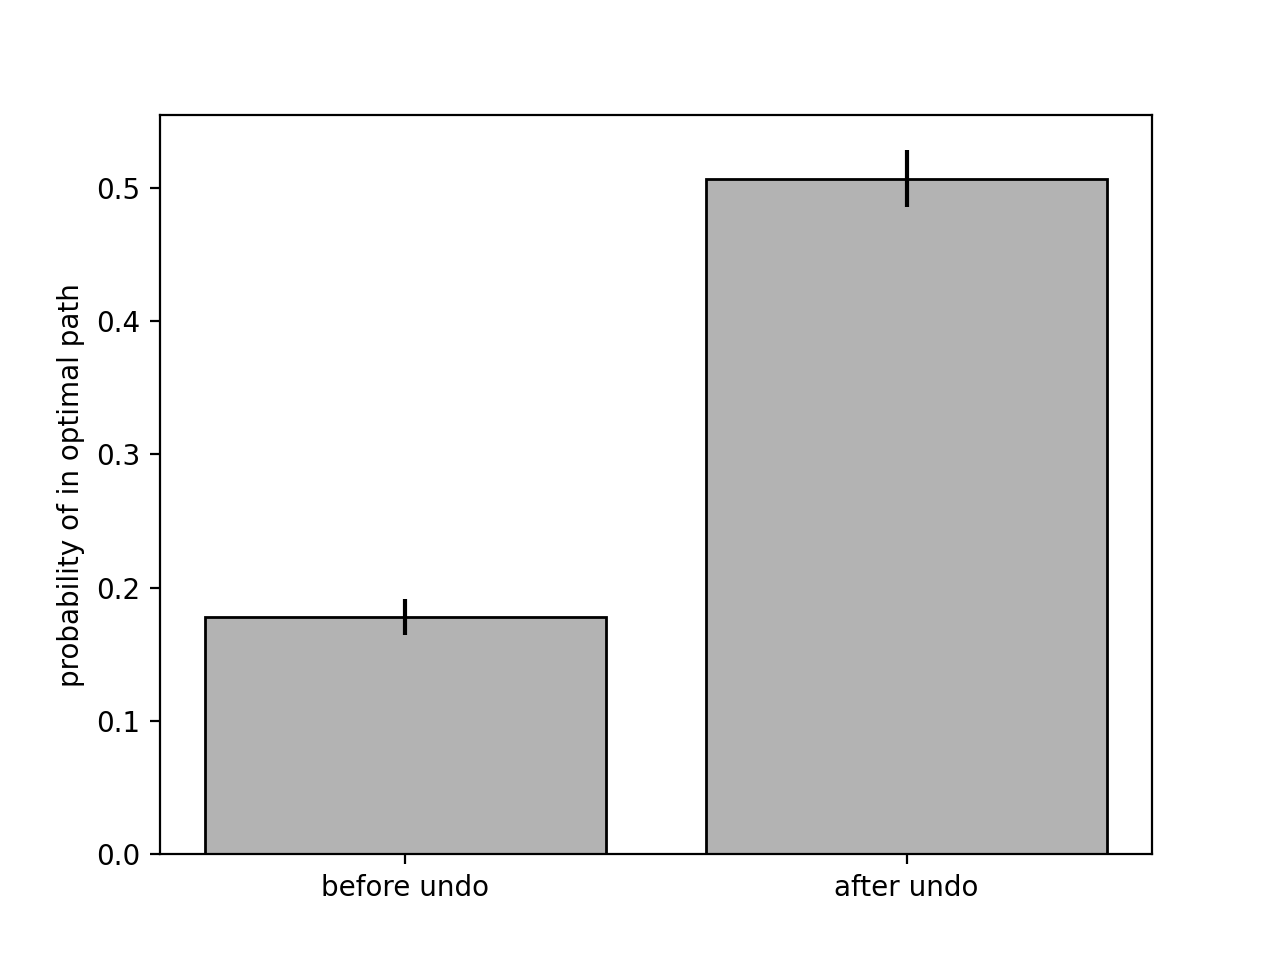

Text(0, 0.5, 'probability of in optimal path')

In [46]:
%matplotlib notebook
plt.figure()
plt.bar(range(2), [np.mean(optimal_before_all_p,axis=0)[1],np.mean(optimal_after_all_p,axis=0)[1]],
        color=[.7,.7,.7], edgecolor = 'k',
        yerr=[np.std(optimal_before_all_p,axis = 0)[1]/np.sqrt(optimal_before_all_p.shape[0]),
              np.std(optimal_after_all_p,axis = 0)[1]/np.sqrt(optimal_after_all_p.shape[0])])
plt.xticks([0,1], ['before undo','after undo'])
plt.ylabel('probability of in optimal path')